## Required Libraries

In [1]:
import pandas as pd
import numpy as np
import glob
import math
from math import sqrt
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import gridspec
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
plt.style.use('default')
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot

import pingouin as pg
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LSTM, Flatten, Dropout


from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.optimizers import Adam


2023-09-01 03:47:40.666904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
lstm_data = pd.read_csv('/Users/asur18/Desktop/MSc_Project_Data/My_Appoach/Data/LSTM.csv')

# Convert the 'Date' column to datetime
def convert_to_datetime(df):
    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    except:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
    return df

hybrid_data = convert_to_datetime(lstm_data)

In [3]:
# Fit an ARIMA model to the data
model = ARIMA(hybrid_data["Water Column"], order=(5,1,0))
fit = model.fit()

# Add ARIMA components to a new dataframe
features_df = pd.DataFrame(index=hybrid_data.index)
features_df["Date"] = hybrid_data['Date']
features_df["Water Column"] = hybrid_data["Water Column"]
features_df["Water Temperature"] = hybrid_data["Water Temperature"]
features_df["degree_C Soil Temperature"] = hybrid_data["degree_C Soil Temperature"]
features_df["mS/cm Saturation Extract EC"] = hybrid_data["mS/cm Saturation Extract EC"]

#features_df["trend"] = fit.fittedvalues
features_df["residual"] = fit.resid
#features_df["seasonal"] = hybrid_data["Water Column"] - features_df["trend"] - features_df["residual"]


In [5]:
# # Set the Date as the index
features_df.set_index('Date', inplace=True)
features_df.head(5)

,Water Column,Water Temperature,degree_C Soil Temperature,mS/cm Saturation Extract EC,residual
Date,,,,,
2021-07-15,17.081110,15.201198,21.235897,0.540231,17.081110
2021-07-22,17.083686,15.200632,20.881845,0.556539,0.002575
2021-07-29,17.082886,15.200722,21.578720,0.519045,-0.000224
2021-08-05,17.032243,15.198781,22.060417,0.497743,-0.050852
2021-08-12,16.995771,15.197786,22.123363,0.491604,-0.047510


In [6]:
# Scale the selected data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features_df)

In [7]:
# Setting the random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the lookback period
look_back = 5

# Reshape the data into sequences with a lookback period of 5
def create_sequences(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back):
        a = data[i:(i+look_back), :]
        X.append(a)
        Y.append(data[i+look_back, 0])  # Predict the next water level
    return np.array(X), np.array(Y)

X, y = create_sequences(scaled_data, look_back)

In [8]:
# Split the reshaped data into training and testing datasets
split_index = int(0.85 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Print the shape of the reshaped data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (83, 5, 5)
Shape of y_train: (83,)
Shape of X_test: (15, 5, 5)
Shape of y_test: (15,)


In [9]:
def nash_sutcliffe_efficiency(observed, predicted):
    """
    Compute the Nash-Sutcliffe Efficiency.

    Parameters:
    - observed : list or array-like
        List or array of observed values
    - predicted : list or array-like
        List or array of predicted values

    Returns:
    - nse : float
        Nash-Sutcliffe Efficiency
    """
    observed_mean = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - observed_mean) ** 2)
    nse = 1 - (numerator / denominator)
    return nse

In [10]:
import numpy as np

def mean_absolute_percentage_error(observed, predicted):
    """
    Compute the Mean Absolute Percentage Error.

    Parameters:
    - observed : list or array-like
        List or array of observed values
    - predicted : list or array-like
        List or array of predicted values

    Returns:
    - mape : float
        Mean Absolute Percentage Error
    """
    # Calculate the absolute percentage error for each data point
    absolute_percentage_error = np.abs((observed - predicted) / observed)

    # Calculate the mean of the absolute percentage errors
    mape = 100 * np.mean(absolute_percentage_error)

    return mape

In [11]:
import time

def run_loop(learning_rate, num_units, dropout_rate, batch_size, loop, num_epochs):
    for i in range(loop):
        
        # Start time capture
        start_time = time.time()
        
        # Define the LSTM model
        model = Sequential()
        # Add the first LSTM layer
        model.add(LSTM(num_units, input_shape=(look_back, 5), kernel_initializer='glorot_uniform'))
        #model.add(Dropout(dropout_rate))
        #model.add(LSTM(num_units))
        #model.add(Dropout(dropout_rate))
        model.add(Dense(1, kernel_initializer='glorot_uniform'))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Train the model with validation data set to the test set
        history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, shuffle=False, verbose=2, validation_data=(X_test, y_test))

        # Display the model summary
        model.summary()

        # Evaluate the model on the validation data
        validation_loss = model.evaluate(X_test, y_test)
        print(f"Validation Loss: {validation_loss}")


        # Use the trained model to make predictions on the training and validation data
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)


        # Reshape the data to inverse transform
        train_pred_reshaped = np.zeros((len(train_pred), X_train.shape[2]))
        train_pred_reshaped[:,0] = train_pred[:,0].reshape(-1)
        test_pred_reshaped = np.zeros((len(test_pred), X_test.shape[2]))
        test_pred_reshaped[:,0] = test_pred[:,0].reshape(-1)

        # Inverse transform the predictions
        train_pred_original = scaler.inverse_transform(train_pred_reshaped)[:,0]
        test_pred_original = scaler.inverse_transform(test_pred_reshaped)[:,0]

        # Inverse transform the target values
        y_train_original = scaler.inverse_transform(np.hstack((y_train.reshape(-1,1), np.zeros((y_train.shape[0], X_train.shape[2]-1)))))[:,0]
        y_test_original = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1), np.zeros((y_test.shape[0], X_test.shape[2]-1)))))[:,0]

        # Calculate the performance metrics
        mape_train = mean_absolute_percentage_error(y_train_original, train_pred_original)
        rmse_train = np.sqrt(mean_squared_error(y_train_original, train_pred_original))
        nse_train = nash_sutcliffe_efficiency(y_train_original, train_pred_original)

        mape_test = mean_absolute_percentage_error(y_test_original, test_pred_original)
        rmse_test = np.sqrt(mean_squared_error(y_test_original, test_pred_original))
        nse_test = nash_sutcliffe_efficiency(y_test_original, test_pred_original)
        
        # End time capture
        end_time = time.time()
        # Calculate elapsed time
        elapsed_time = end_time - start_time

        results.append((model, {"train_pred_original": train_pred_original, "test_pred_original": test_pred_original, "y_train_original": y_train_original, "y_test_original": y_test_original, "mape_train": mape_train, "rmse_train": rmse_train, "nse_train": nse_train, "mape_test": mape_test, "rmse_test": rmse_test, "nse_test": nse_test, "elapsed_time": elapsed_time}))
        
        

## Executing the model with 100 Iteration

Epoch 1/40
6/6 - 2s - loss: 0.5299 - val_loss: 9.1333e-04 - 2s/epoch - 293ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2608 - val_loss: 0.0164 - 44ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1063 - val_loss: 0.0502 - 44ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0313 - val_loss: 0.0912 - 40ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0142 - val_loss: 0.1170 - 42ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0177 - val_loss: 0.1126 - 39ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0146 - val_loss: 0.0918 - 39ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0104 - val_loss: 0.0728 - 40ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0109 - val_loss: 0.0616 - 42ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0122 - val_loss: 0.0570 - 41ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0117 - val_loss: 0.0560 - 41ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0104 - val_loss: 0.0556 - 41ms/epoch - 7ms/step
Epoch 13/40
6/6 - 0s - loss: 0.0095 - val_loss: 0.0537 - 

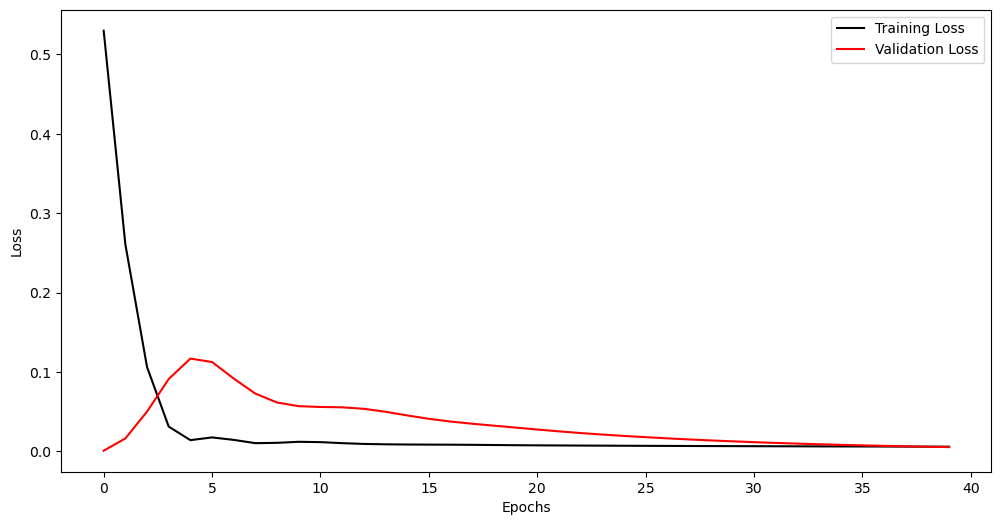

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.1736 - val_loss: 0.0061 - 2s/epoch - 290ms/step
Epoch 2/40
6/6 - 0s - loss: 0.0393 - val_loss: 0.0330 - 43ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0136 - val_loss: 0.0538 - 43ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0202 - val_loss: 0.0456 - 38ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0130 - val_loss: 0.0295 - 37ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0103 - val_loss: 0.0204 - 38ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0122 - val_loss: 0.0182 - 38ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0114 - val_loss: 0.0196 - 38ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0094 - val_loss: 0.0209 - 40ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0086 - val_loss: 0.0199 - 38ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0082 - val_loss: 0.0169 - 41ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0079 - val_loss: 0.0141 - 38ms/epoch - 6ms/step
Epoch 13/

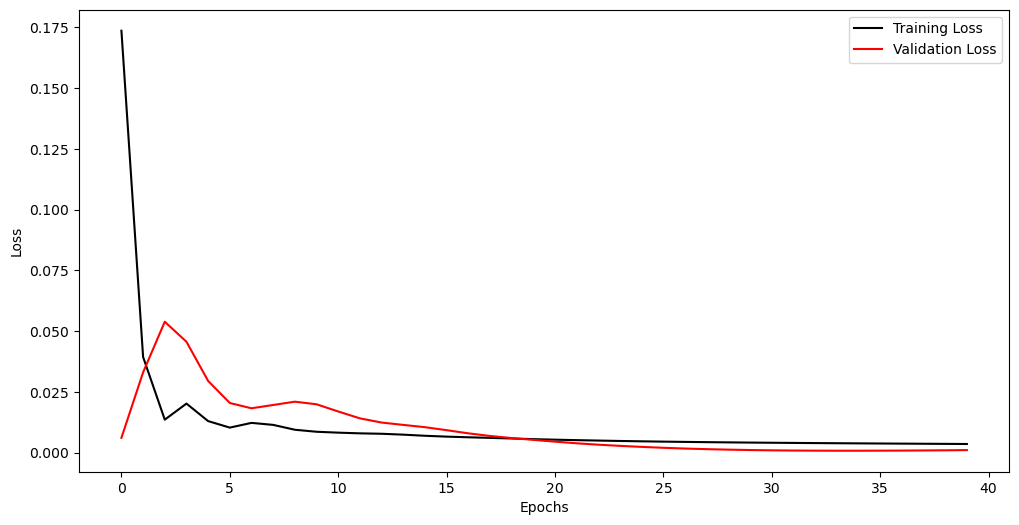

1/1 [==============================] - 0s 21ms/step
Epoch 1/40
6/6 - 2s - loss: 0.8023 - val_loss: 0.0105 - 2s/epoch - 288ms/step
Epoch 2/40
6/6 - 0s - loss: 0.4647 - val_loss: 7.1483e-04 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.2464 - val_loss: 0.0138 - 44ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.1078 - val_loss: 0.0445 - 44ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0369 - val_loss: 0.0827 - 41ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0192 - val_loss: 0.1088 - 39ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0224 - val_loss: 0.1082 - 40ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0199 - val_loss: 0.0910 - 38ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0154 - val_loss: 0.0738 - 39ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0151 - val_loss: 0.0628 - 37ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0163 - val_loss: 0.0577 - 38ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0161 - val_loss: 0.0562 - 39ms/epoch - 6ms/step
Epoch

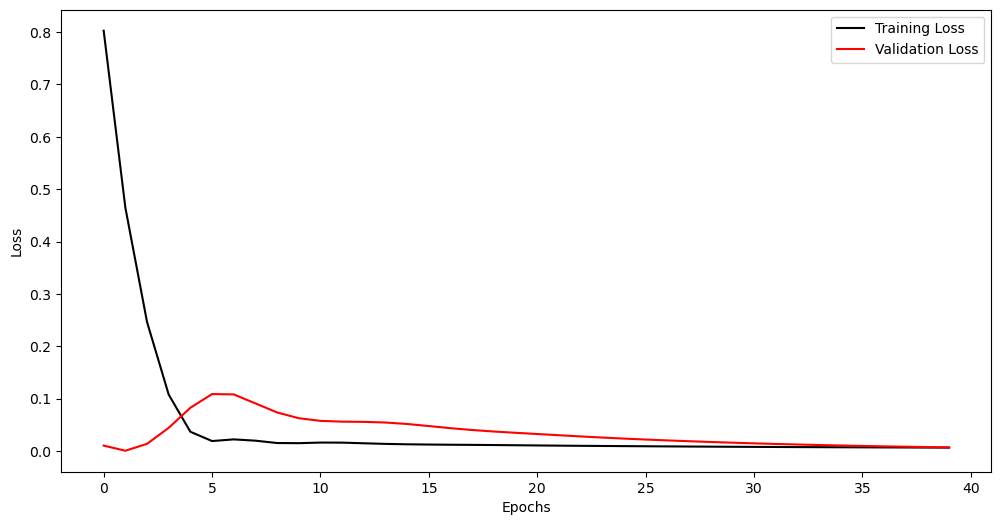

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.6017 - val_loss: 0.0021 - 2s/epoch - 291ms/step
Epoch 2/40
6/6 - 0s - loss: 0.3712 - val_loss: 0.0148 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.2145 - val_loss: 0.0391 - 44ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.1061 - val_loss: 0.0740 - 39ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0428 - val_loss: 0.1136 - 38ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0203 - val_loss: 0.1415 - 39ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0194 - val_loss: 0.1416 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0174 - val_loss: 0.1217 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0137 - val_loss: 0.1003 - 38ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0134 - val_loss: 0.0857 - 38ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0145 - val_loss: 0.0778 - 38ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0144 - val_loss: 0.0740 - 39ms/epoch - 6ms/step
Epoch 13/

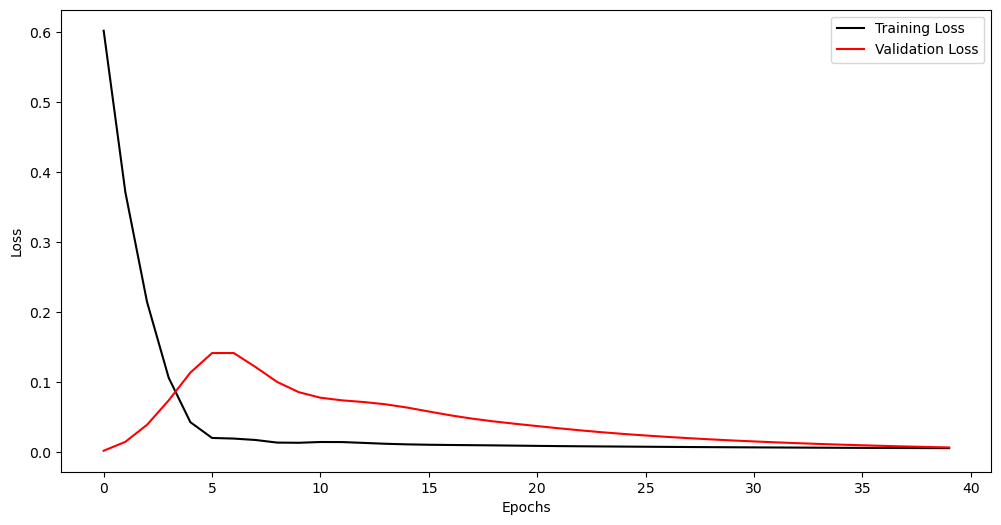

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.4962 - val_loss: 0.0014 - 2s/epoch - 288ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2434 - val_loss: 0.0167 - 44ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0983 - val_loss: 0.0553 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0339 - val_loss: 0.1010 - 39ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0247 - val_loss: 0.1223 - 39ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0255 - val_loss: 0.1094 - 39ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0188 - val_loss: 0.0854 - 38ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0154 - val_loss: 0.0673 - 38ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0164 - val_loss: 0.0579 - 38ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0172 - val_loss: 0.0547 - 38ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0160 - val_loss: 0.0542 - 40ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0144 - val_loss: 0.0535 - 39ms/epoch - 6ms/step
Epoch 13/

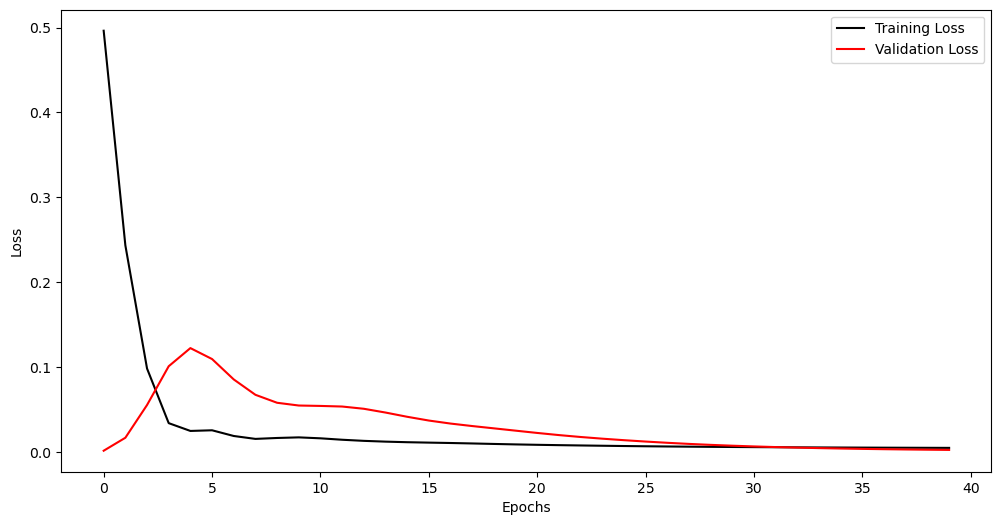

1/1 [==============================] - 0s 22ms/step
Epoch 1/40
6/6 - 2s - loss: 0.4175 - val_loss: 0.0022 - 2s/epoch - 289ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2057 - val_loss: 0.0205 - 41ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0783 - val_loss: 0.0560 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0214 - val_loss: 0.0953 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0160 - val_loss: 0.1102 - 37ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0173 - val_loss: 0.0949 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0107 - val_loss: 0.0732 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0094 - val_loss: 0.0592 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0114 - val_loss: 0.0532 - 36ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0115 - val_loss: 0.0521 - 37ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0100 - val_loss: 0.0521 - 36ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0087 - val_loss: 0.0502 - 36ms/epoch - 6ms/step
Epoch 13/

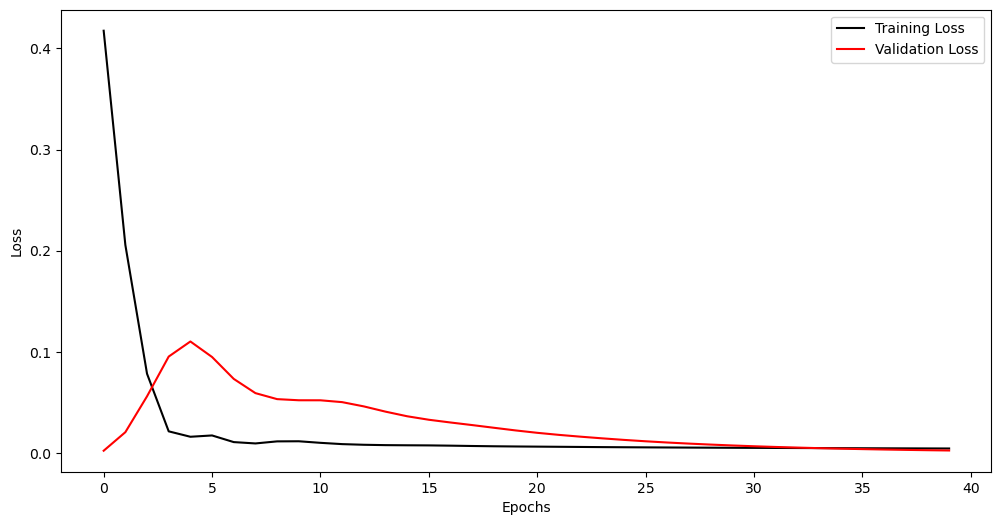

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.2655 - val_loss: 0.0086 - 2s/epoch - 288ms/step
Epoch 2/40
6/6 - 0s - loss: 0.0992 - val_loss: 0.0334 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0239 - val_loss: 0.0654 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0117 - val_loss: 0.0813 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0157 - val_loss: 0.0706 - 37ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0100 - val_loss: 0.0522 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0078 - val_loss: 0.0397 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0097 - val_loss: 0.0343 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0097 - val_loss: 0.0331 - 38ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0080 - val_loss: 0.0328 - 37ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0070 - val_loss: 0.0308 - 36ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0067 - val_loss: 0.0271 - 38ms/epoch - 6ms/step
Epoch 13/

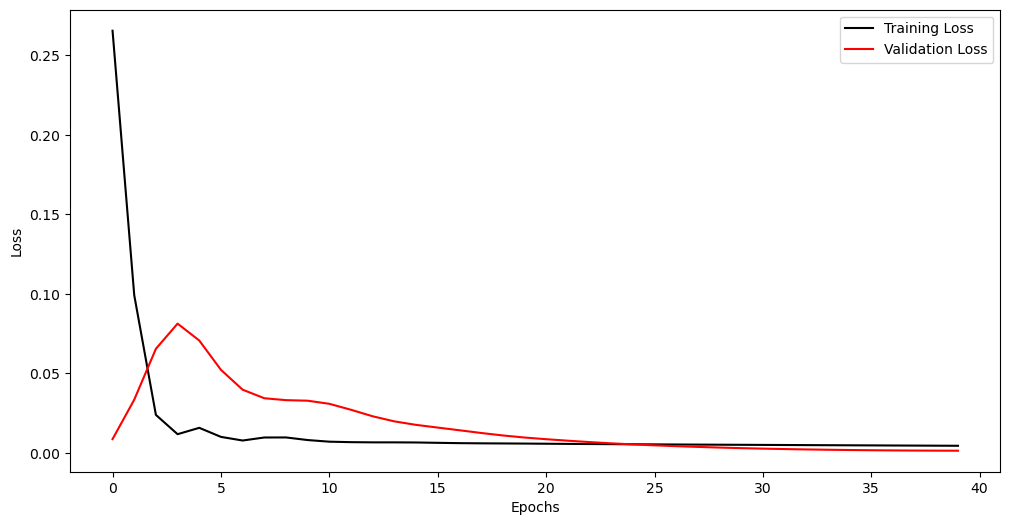

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.1953 - val_loss: 0.0143 - 2s/epoch - 287ms/step
Epoch 2/40
6/6 - 0s - loss: 0.0583 - val_loss: 0.0436 - 41ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0156 - val_loss: 0.0694 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0179 - val_loss: 0.0662 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0135 - val_loss: 0.0469 - 37ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0085 - val_loss: 0.0321 - 39ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0100 - val_loss: 0.0256 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0105 - val_loss: 0.0241 - 36ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0086 - val_loss: 0.0239 - 39ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0071 - val_loss: 0.0222 - 38ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0066 - val_loss: 0.0185 - 37ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0063 - val_loss: 0.0147 - 39ms/epoch - 6ms/step
Epoch 13/

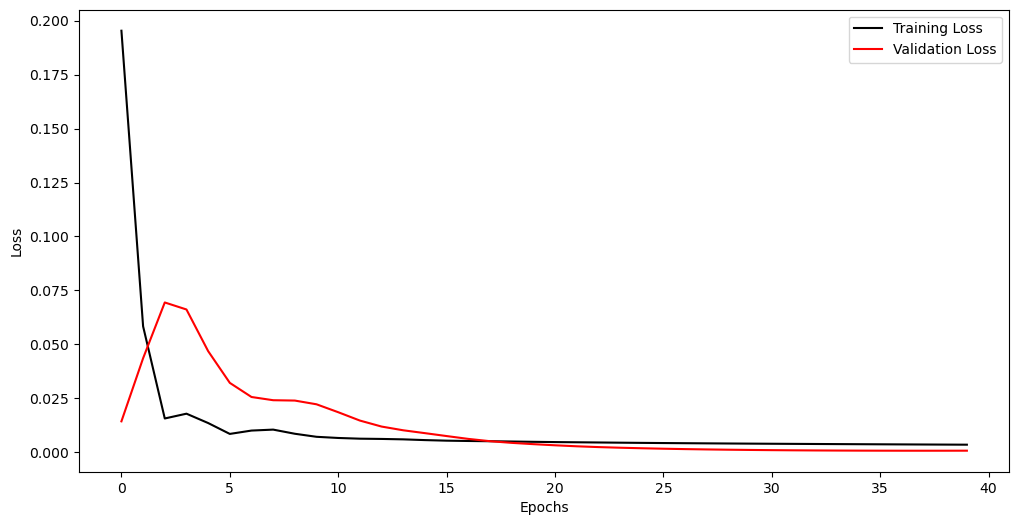

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3853 - val_loss: 0.0015 - 2s/epoch - 284ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1656 - val_loss: 0.0171 - 41ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0533 - val_loss: 0.0507 - 41ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0195 - val_loss: 0.0805 - 39ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0227 - val_loss: 0.0818 - 39ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0198 - val_loss: 0.0638 - 38ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0137 - val_loss: 0.0466 - 38ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0137 - val_loss: 0.0371 - 39ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0151 - val_loss: 0.0337 - 39ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0144 - val_loss: 0.0334 - 37ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0127 - val_loss: 0.0334 - 39ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0115 - val_loss: 0.0318 - 38ms/epoch - 6ms/step
Epoch 13/

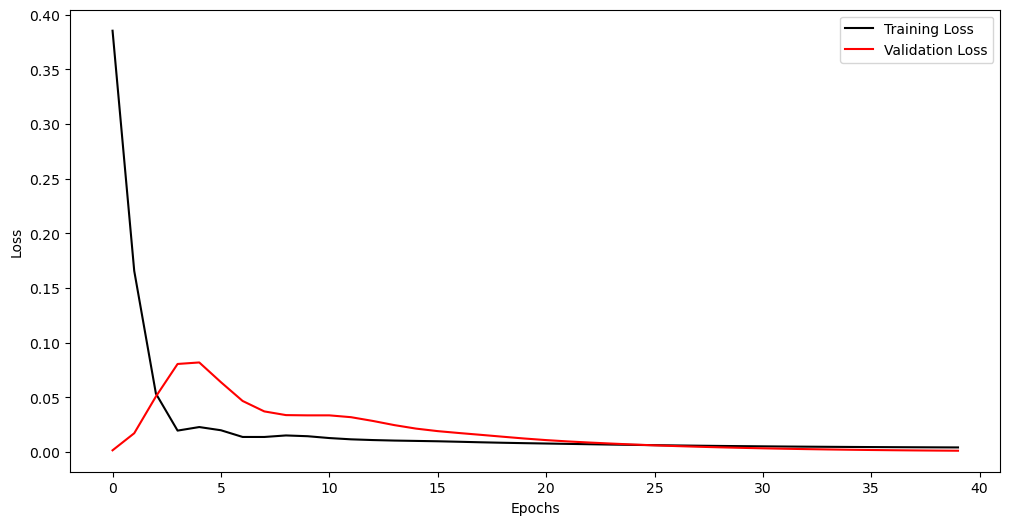

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.4802 - val_loss: 0.0051 - 2s/epoch - 285ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2494 - val_loss: 0.0148 - 45ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1190 - val_loss: 0.0406 - 49ms/epoch - 8ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0522 - val_loss: 0.0732 - 47ms/epoch - 8ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0296 - val_loss: 0.0981 - 47ms/epoch - 8ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0273 - val_loss: 0.1028 - 45ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0253 - val_loss: 0.0912 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0211 - val_loss: 0.0754 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0189 - val_loss: 0.0628 - 37ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0187 - val_loss: 0.0552 - 38ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0185 - val_loss: 0.0513 - 39ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0174 - val_loss: 0.0495 - 40ms/epoch - 7ms/step
Epoch 13/

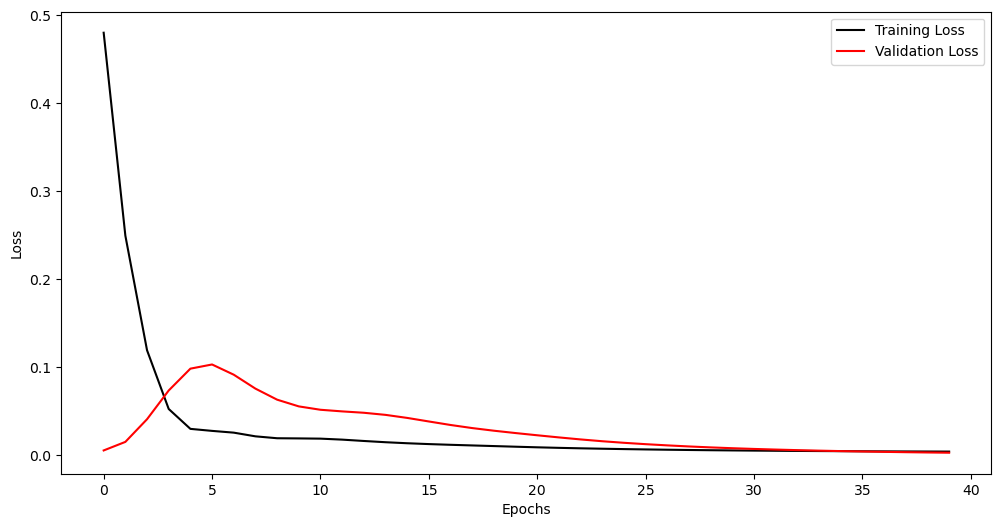

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.1904 - val_loss: 0.0234 - 2s/epoch - 286ms/step
Epoch 2/40
6/6 - 0s - loss: 0.0508 - val_loss: 0.0644 - 43ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0148 - val_loss: 0.0950 - 45ms/epoch - 8ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0181 - val_loss: 0.0891 - 40ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0137 - val_loss: 0.0658 - 38ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0096 - val_loss: 0.0480 - 38ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0113 - val_loss: 0.0400 - 38ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0118 - val_loss: 0.0384 - 39ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0100 - val_loss: 0.0386 - 39ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0086 - val_loss: 0.0369 - 37ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0080 - val_loss: 0.0325 - 39ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0077 - val_loss: 0.0273 - 38ms/epoch - 6ms/step
Epoch 13/

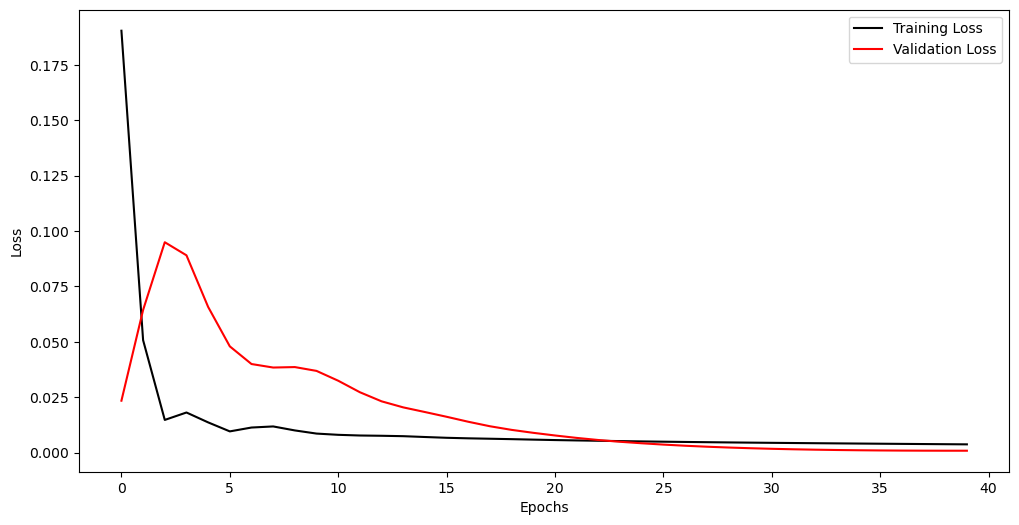

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.4467 - val_loss: 0.0132 - 2s/epoch - 353ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2223 - val_loss: 0.0052 - 43ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0881 - val_loss: 0.0165 - 44ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0301 - val_loss: 0.0377 - 38ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0272 - val_loss: 0.0483 - 38ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0302 - val_loss: 0.0420 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0231 - val_loss: 0.0315 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0194 - val_loss: 0.0246 - 40ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0197 - val_loss: 0.0219 - 40ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0192 - val_loss: 0.0217 - 38ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0175 - val_loss: 0.0226 - 38ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0159 - val_loss: 0.0230 - 39ms/epoch - 6ms/step
Epoch 13/

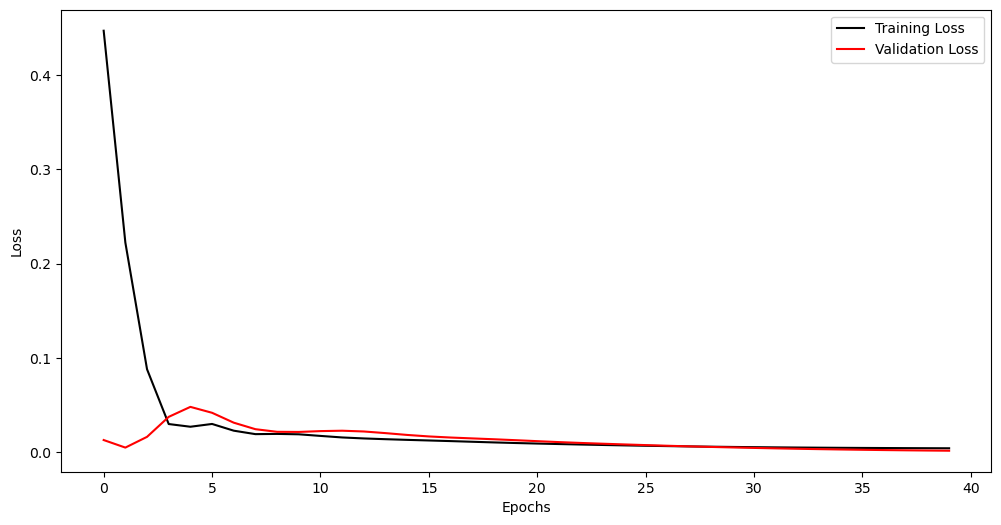

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.4991 - val_loss: 0.0010 - 2s/epoch - 287ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2762 - val_loss: 0.0145 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1397 - val_loss: 0.0453 - 44ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0599 - val_loss: 0.0869 - 38ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0253 - val_loss: 0.1253 - 39ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0196 - val_loss: 0.1414 - 38ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0197 - val_loss: 0.1316 - 39ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0165 - val_loss: 0.1113 - 38ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0146 - val_loss: 0.0938 - 39ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0151 - val_loss: 0.0830 - 39ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0157 - val_loss: 0.0778 - 38ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0152 - val_loss: 0.0756 - 40ms/epoch - 7ms/step
Epoch 13/

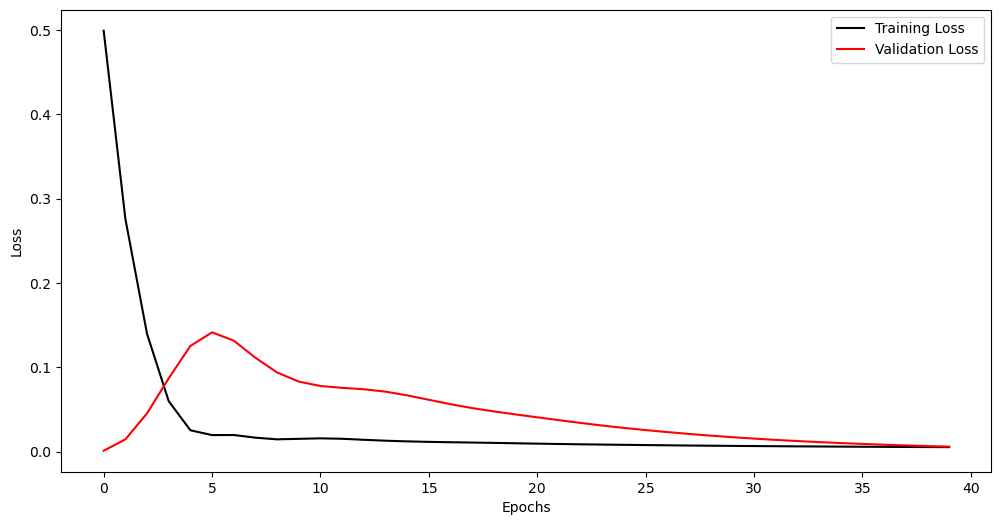

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.1964 - val_loss: 0.0124 - 2s/epoch - 286ms/step
Epoch 2/40
6/6 - 0s - loss: 0.0631 - val_loss: 0.0437 - 43ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0212 - val_loss: 0.0754 - 44ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0223 - val_loss: 0.0803 - 39ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0203 - val_loss: 0.0649 - 38ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0150 - val_loss: 0.0497 - 38ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0150 - val_loss: 0.0418 - 39ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0157 - val_loss: 0.0399 - 40ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0145 - val_loss: 0.0409 - 39ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0128 - val_loss: 0.0415 - 39ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0118 - val_loss: 0.0399 - 40ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0111 - val_loss: 0.0364 - 39ms/epoch - 6ms/step
Epoch 13/

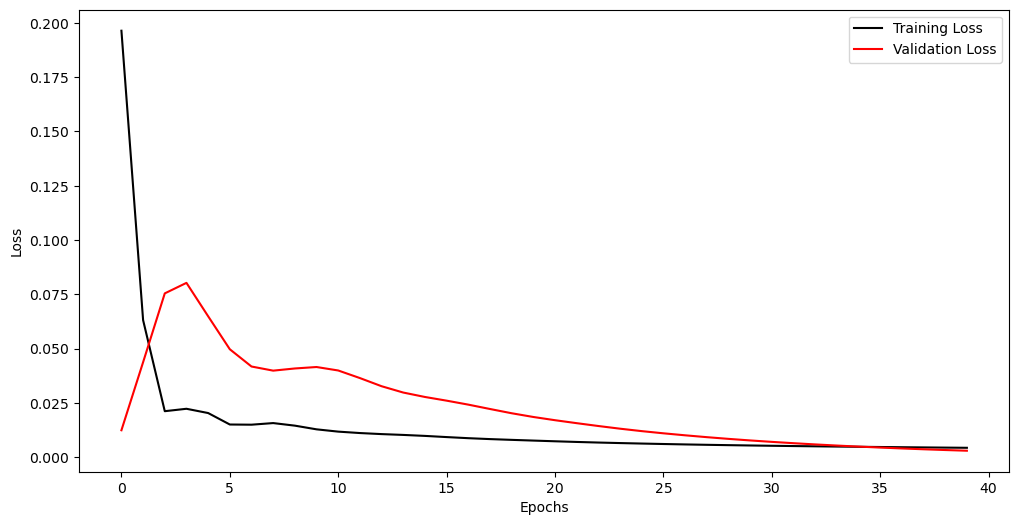

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3046 - val_loss: 0.0074 - 2s/epoch - 287ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1439 - val_loss: 0.0332 - 43ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0529 - val_loss: 0.0761 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0250 - val_loss: 0.1091 - 39ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0268 - val_loss: 0.1039 - 39ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0210 - val_loss: 0.0802 - 39ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0167 - val_loss: 0.0619 - 39ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0179 - val_loss: 0.0534 - 39ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0183 - val_loss: 0.0514 - 38ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0164 - val_loss: 0.0518 - 39ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0144 - val_loss: 0.0507 - 39ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0131 - val_loss: 0.0467 - 38ms/epoch - 6ms/step
Epoch 13/

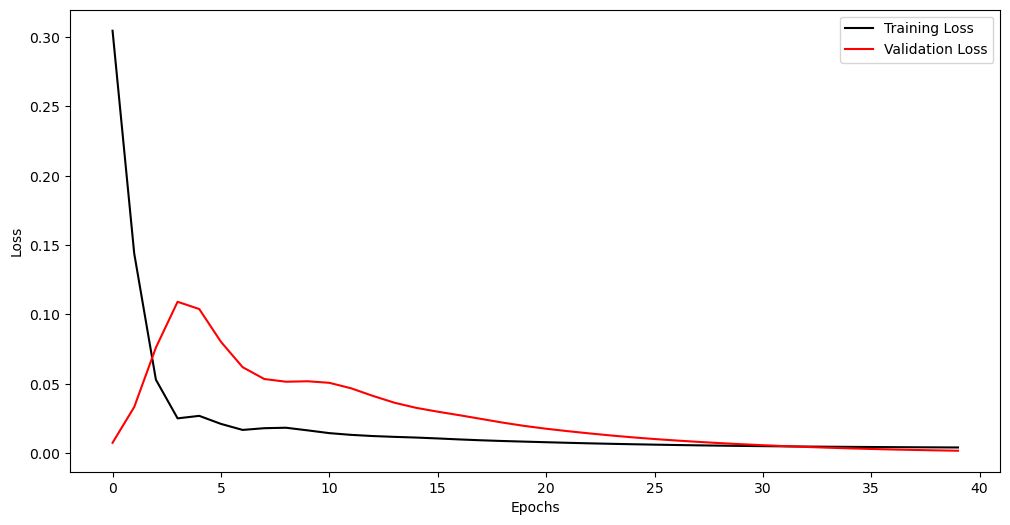

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.5168 - val_loss: 0.0010 - 2s/epoch - 288ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2813 - val_loss: 0.0063 - 46ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1327 - val_loss: 0.0278 - 44ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0477 - val_loss: 0.0605 - 39ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0177 - val_loss: 0.0893 - 40ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0184 - val_loss: 0.0949 - 39ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0179 - val_loss: 0.0804 - 42ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0130 - val_loss: 0.0631 - 41ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0122 - val_loss: 0.0518 - 42ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0135 - val_loss: 0.0466 - 39ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0136 - val_loss: 0.0453 - 49ms/epoch - 8ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0124 - val_loss: 0.0452 - 42ms/epoch - 7ms/step
Epoch 13/

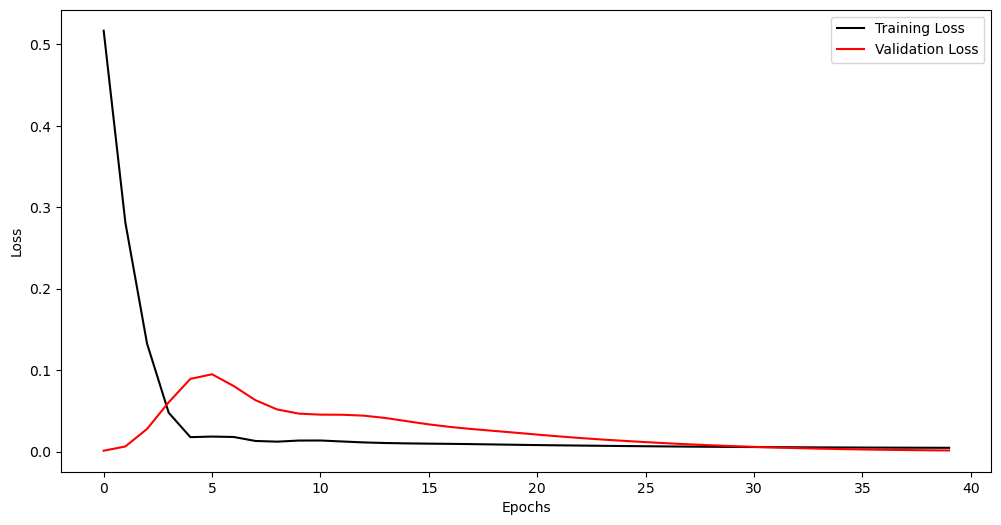

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3953 - val_loss: 0.0090 - 2s/epoch - 287ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1791 - val_loss: 0.0363 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0680 - val_loss: 0.0762 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0289 - val_loss: 0.1095 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0271 - val_loss: 0.1145 - 36ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0250 - val_loss: 0.0966 - 36ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0190 - val_loss: 0.0758 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0175 - val_loss: 0.0617 - 36ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0185 - val_loss: 0.0546 - 36ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0183 - val_loss: 0.0519 - 36ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0168 - val_loss: 0.0506 - 37ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0152 - val_loss: 0.0486 - 37ms/epoch - 6ms/step
Epoch 13/

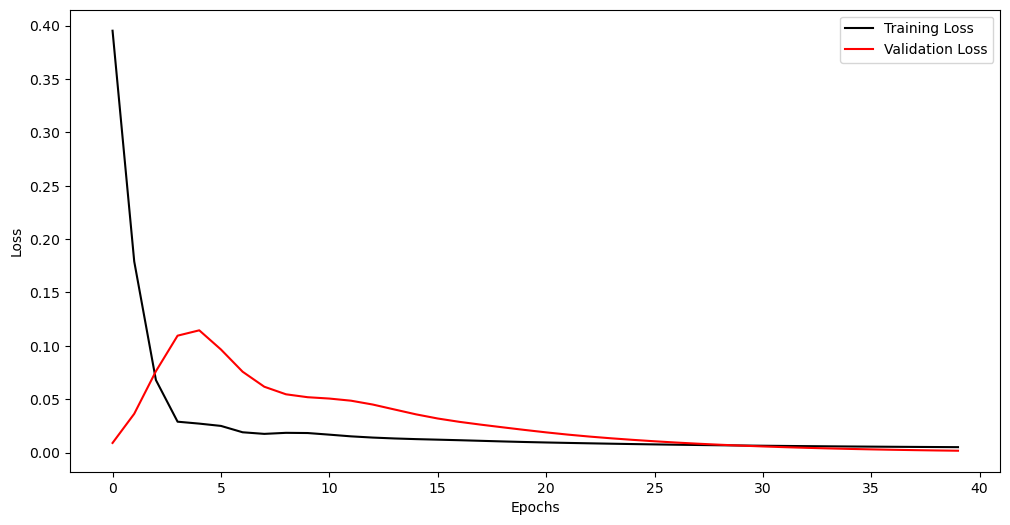

1/1 [==============================] - 0s 26ms/step
Epoch 1/40
6/6 - 3s - loss: 0.5123 - val_loss: 0.0016 - 3s/epoch - 473ms/step
Epoch 2/40
6/6 - 0s - loss: 0.3034 - val_loss: 0.0134 - 44ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1656 - val_loss: 0.0436 - 44ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0773 - val_loss: 0.0886 - 40ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0348 - val_loss: 0.1340 - 38ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0263 - val_loss: 0.1529 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0247 - val_loss: 0.1388 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0196 - val_loss: 0.1135 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0174 - val_loss: 0.0937 - 41ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0181 - val_loss: 0.0824 - 40ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0184 - val_loss: 0.0773 - 41ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0172 - val_loss: 0.0750 - 39ms/epoch - 6ms/step
Epoch 13/

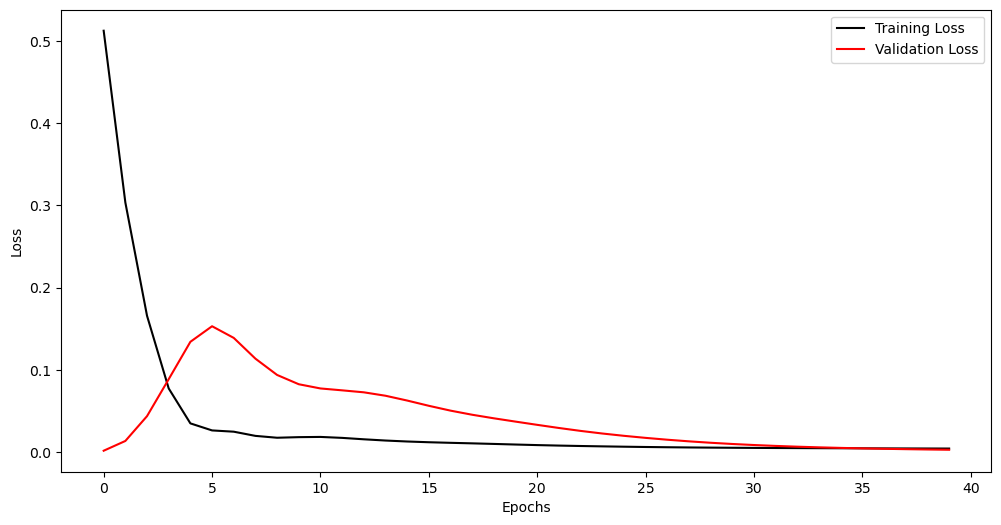

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.5195 - val_loss: 0.0073 - 2s/epoch - 287ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2626 - val_loss: 0.0382 - 43ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1125 - val_loss: 0.0894 - 41ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0428 - val_loss: 0.1434 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0296 - val_loss: 0.1673 - 36ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0292 - val_loss: 0.1511 - 36ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0221 - val_loss: 0.1203 - 36ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0181 - val_loss: 0.0958 - 36ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0189 - val_loss: 0.0818 - 36ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0195 - val_loss: 0.0755 - 36ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0180 - val_loss: 0.0727 - 36ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0158 - val_loss: 0.0699 - 36ms/epoch - 6ms/step
Epoch 13/

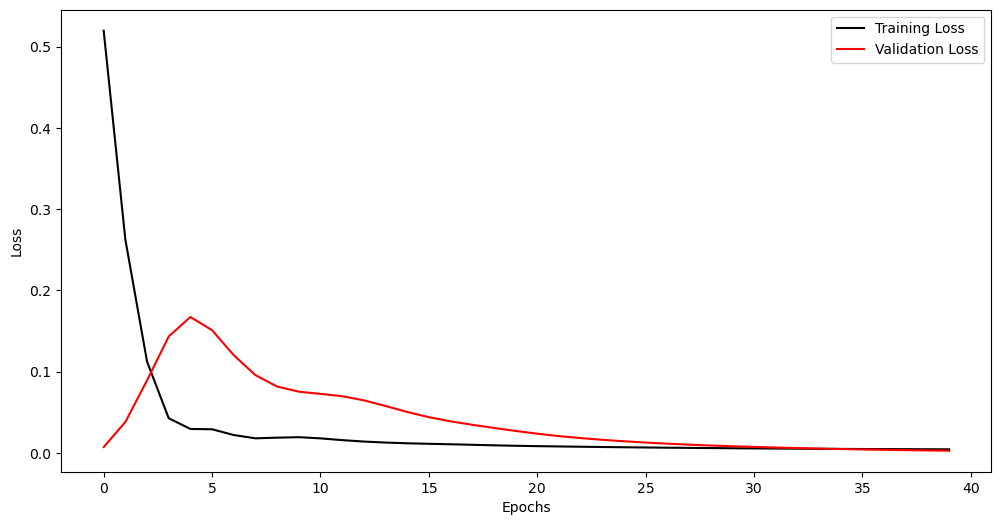

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3434 - val_loss: 0.0158 - 2s/epoch - 287ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1518 - val_loss: 0.0587 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0539 - val_loss: 0.1168 - 43ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0261 - val_loss: 0.1552 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0261 - val_loss: 0.1470 - 37ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0200 - val_loss: 0.1155 - 36ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0150 - val_loss: 0.0887 - 36ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0159 - val_loss: 0.0738 - 36ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0169 - val_loss: 0.0677 - 38ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0156 - val_loss: 0.0656 - 37ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0135 - val_loss: 0.0633 - 36ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0119 - val_loss: 0.0583 - 36ms/epoch - 6ms/step
Epoch 13/

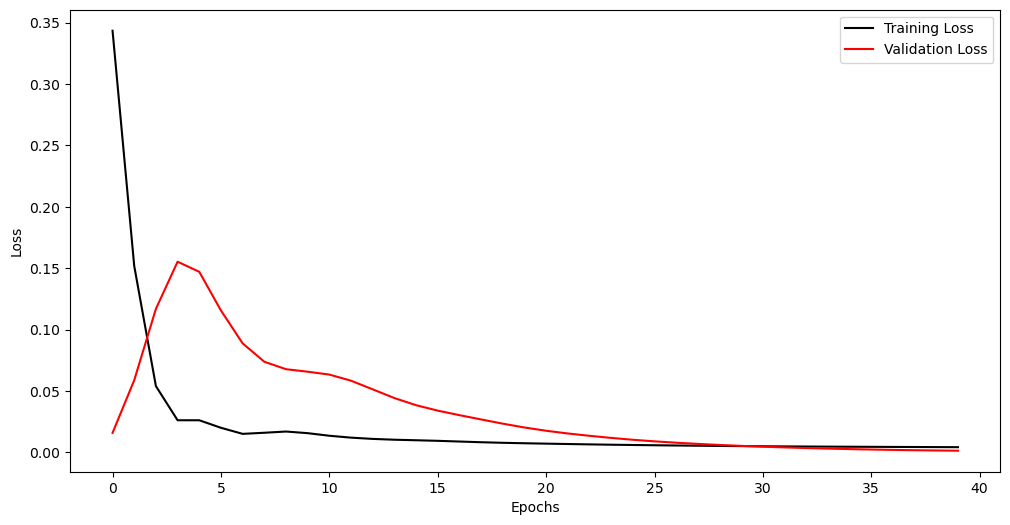

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.4101 - val_loss: 0.0051 - 2s/epoch - 292ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1741 - val_loss: 0.0402 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0581 - val_loss: 0.0973 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0256 - val_loss: 0.1402 - 39ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0263 - val_loss: 0.1368 - 36ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0201 - val_loss: 0.1069 - 36ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0138 - val_loss: 0.0800 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0142 - val_loss: 0.0649 - 39ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0157 - val_loss: 0.0589 - 37ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0148 - val_loss: 0.0577 - 36ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0127 - val_loss: 0.0567 - 39ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0111 - val_loss: 0.0533 - 36ms/epoch - 6ms/step
Epoch 13/

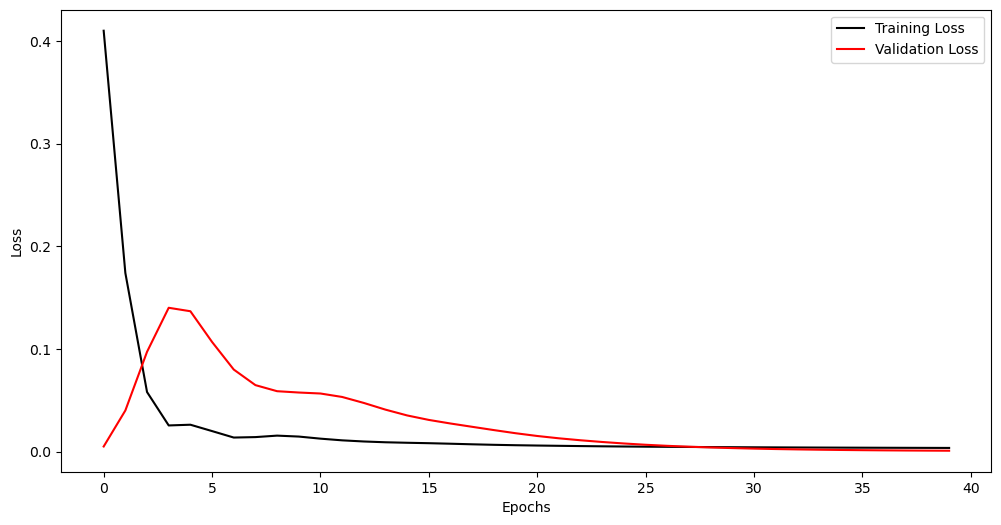

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.2736 - val_loss: 0.0028 - 2s/epoch - 291ms/step
Epoch 2/40
6/6 - 0s - loss: 0.0958 - val_loss: 0.0247 - 43ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0233 - val_loss: 0.0574 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0165 - val_loss: 0.0733 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0208 - val_loss: 0.0634 - 37ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0148 - val_loss: 0.0468 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0124 - val_loss: 0.0361 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0138 - val_loss: 0.0321 - 38ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0136 - val_loss: 0.0324 - 36ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0120 - val_loss: 0.0337 - 50ms/epoch - 8ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0108 - val_loss: 0.0337 - 38ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0103 - val_loss: 0.0315 - 37ms/epoch - 6ms/step
Epoch 13/

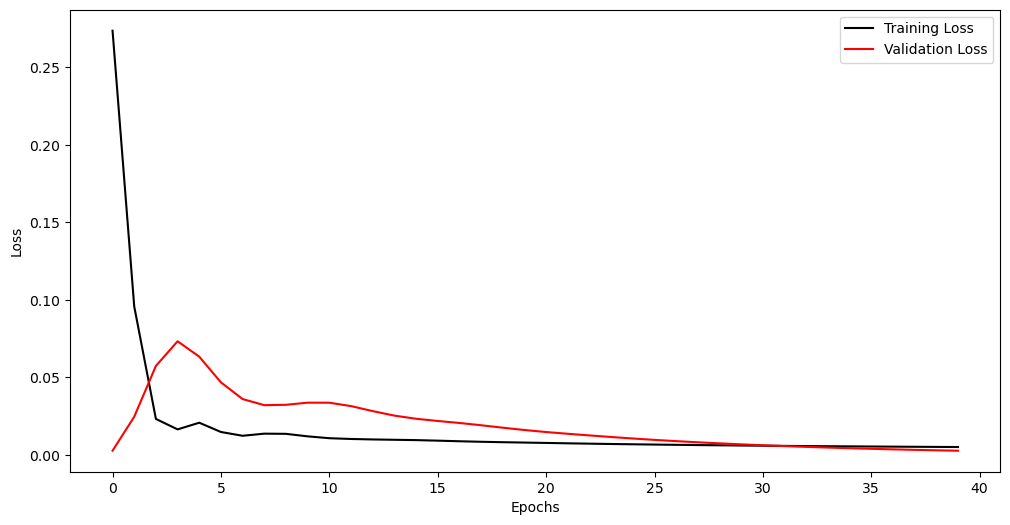

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.6721 - val_loss: 0.0139 - 2s/epoch - 291ms/step
Epoch 2/40
6/6 - 0s - loss: 0.4173 - val_loss: 0.0026 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.2470 - val_loss: 0.0085 - 43ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.1289 - val_loss: 0.0296 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0563 - val_loss: 0.0621 - 38ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0261 - val_loss: 0.0925 - 40ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0231 - val_loss: 0.1017 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0224 - val_loss: 0.0896 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0182 - val_loss: 0.0723 - 37ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0167 - val_loss: 0.0596 - 41ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0175 - val_loss: 0.0527 - 37ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0177 - val_loss: 0.0499 - 36ms/epoch - 6ms/step
Epoch 13/

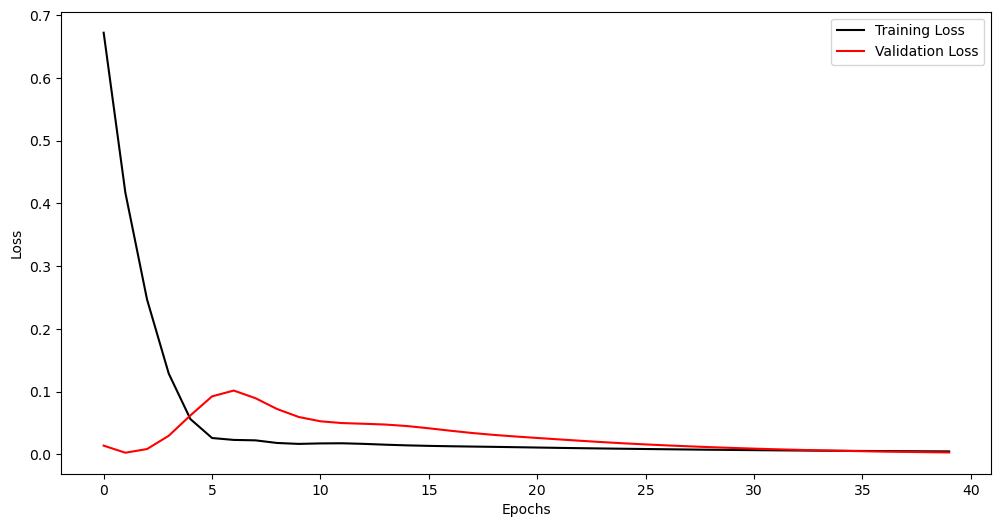

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.5127 - val_loss: 0.0011 - 2s/epoch - 388ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2630 - val_loss: 0.0095 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1124 - val_loss: 0.0333 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0360 - val_loss: 0.0646 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0179 - val_loss: 0.0853 - 37ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0213 - val_loss: 0.0820 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0174 - val_loss: 0.0658 - 36ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0128 - val_loss: 0.0515 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0131 - val_loss: 0.0433 - 36ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0142 - val_loss: 0.0399 - 36ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0135 - val_loss: 0.0391 - 37ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0120 - val_loss: 0.0385 - 37ms/epoch - 6ms/step
Epoch 13/

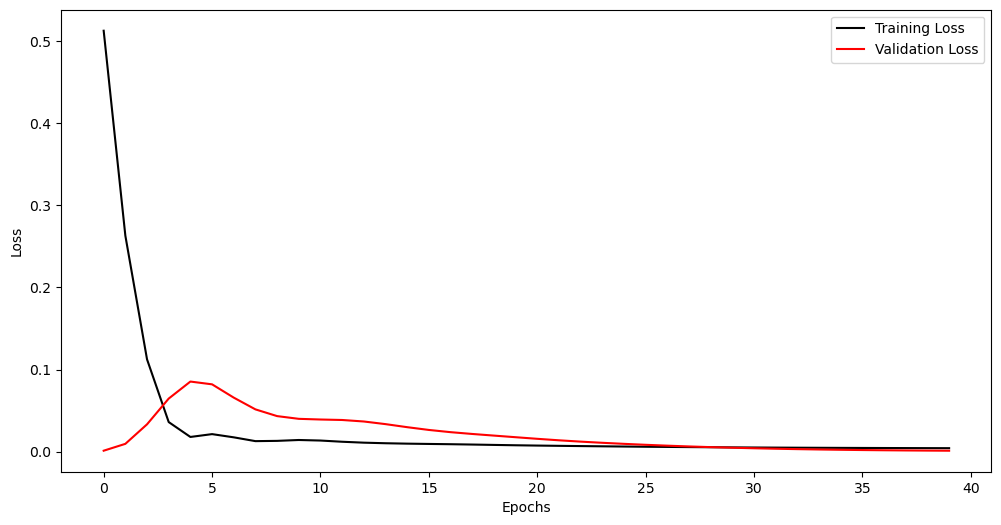

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3207 - val_loss: 0.0090 - 2s/epoch - 291ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1391 - val_loss: 0.0378 - 44ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0468 - val_loss: 0.0788 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0167 - val_loss: 0.1103 - 38ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0166 - val_loss: 0.1100 - 36ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0141 - val_loss: 0.0879 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0095 - val_loss: 0.0660 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0095 - val_loss: 0.0526 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0108 - val_loss: 0.0464 - 37ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0104 - val_loss: 0.0442 - 37ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0090 - val_loss: 0.0427 - 37ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0080 - val_loss: 0.0397 - 37ms/epoch - 6ms/step
Epoch 13/

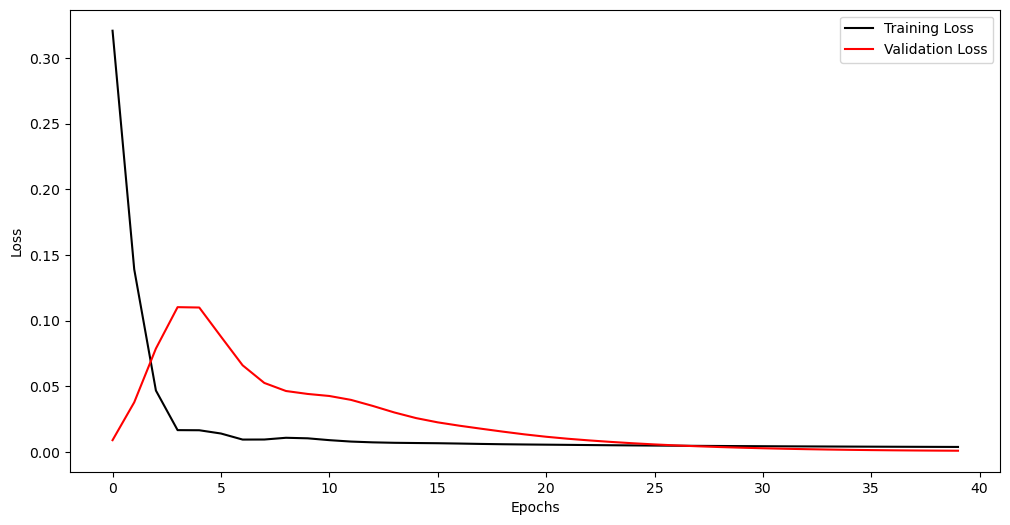

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.4483 - val_loss: 0.0135 - 2s/epoch - 287ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2435 - val_loss: 0.0422 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1186 - val_loss: 0.0846 - 41ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0520 - val_loss: 0.1302 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0315 - val_loss: 0.1561 - 40ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0294 - val_loss: 0.1482 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0243 - val_loss: 0.1221 - 39ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0196 - val_loss: 0.0973 - 38ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0190 - val_loss: 0.0810 - 37ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0195 - val_loss: 0.0719 - 37ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0185 - val_loss: 0.0671 - 38ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0166 - val_loss: 0.0632 - 36ms/epoch - 6ms/step
Epoch 13/

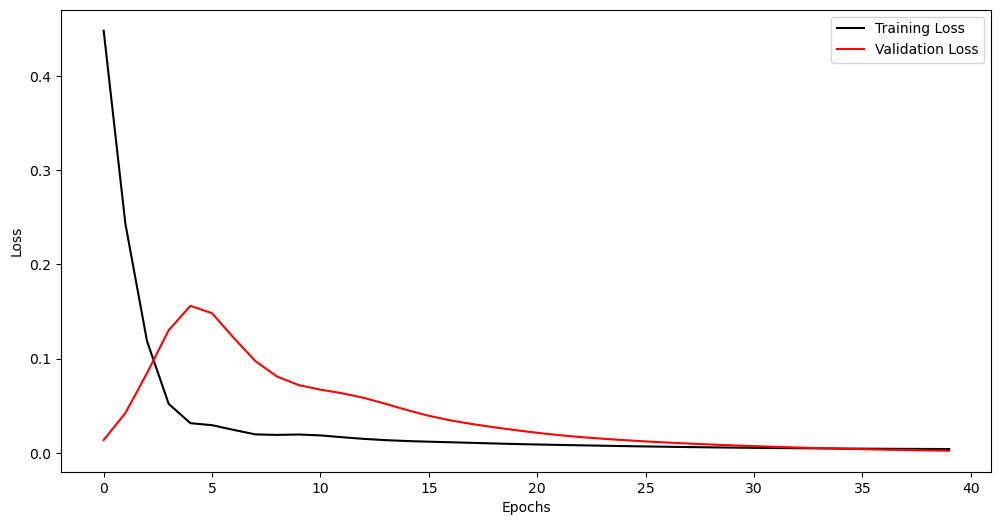

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3363 - val_loss: 0.0038 - 2s/epoch - 293ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1672 - val_loss: 0.0178 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0671 - val_loss: 0.0455 - 43ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0250 - val_loss: 0.0746 - 38ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0226 - val_loss: 0.0814 - 38ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0218 - val_loss: 0.0667 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0161 - val_loss: 0.0501 - 36ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0152 - val_loss: 0.0400 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0164 - val_loss: 0.0357 - 40ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0159 - val_loss: 0.0347 - 41ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0143 - val_loss: 0.0342 - 38ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0131 - val_loss: 0.0326 - 41ms/epoch - 7ms/step
Epoch 13/

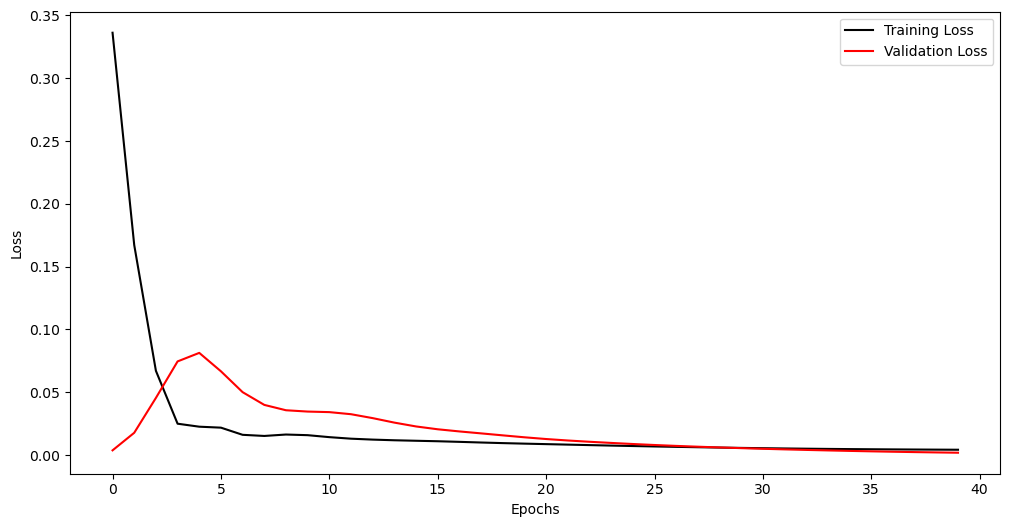

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.5011 - val_loss: 0.0083 - 2s/epoch - 288ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2407 - val_loss: 0.0011 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0937 - val_loss: 0.0149 - 41ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0258 - val_loss: 0.0392 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0125 - val_loss: 0.0565 - 36ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0168 - val_loss: 0.0552 - 36ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0141 - val_loss: 0.0430 - 36ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0098 - val_loss: 0.0317 - 36ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0097 - val_loss: 0.0252 - 38ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0108 - val_loss: 0.0226 - 36ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0106 - val_loss: 0.0224 - 36ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0096 - val_loss: 0.0226 - 36ms/epoch - 6ms/step
Epoch 13/

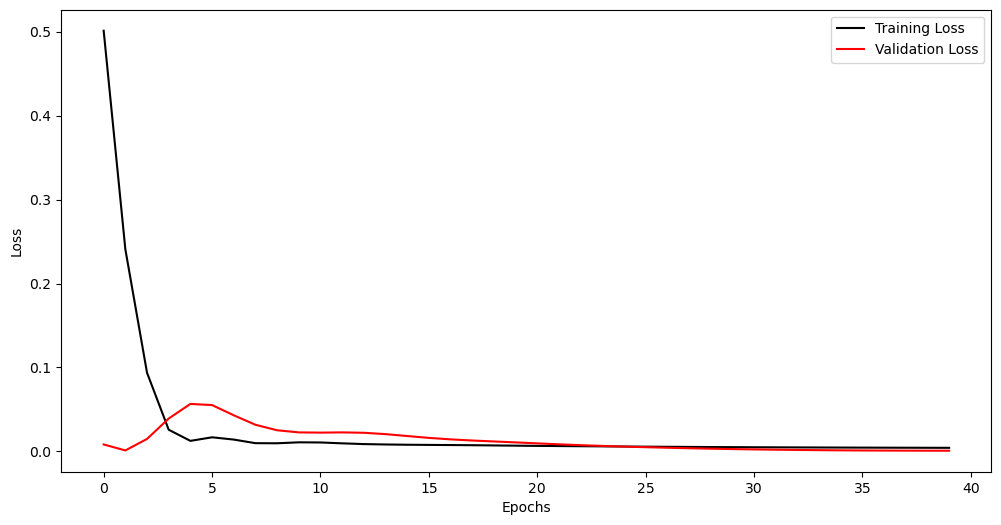

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.2695 - val_loss: 0.0112 - 2s/epoch - 320ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1056 - val_loss: 0.0448 - 48ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0343 - val_loss: 0.0875 - 46ms/epoch - 8ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0209 - val_loss: 0.1099 - 41ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0214 - val_loss: 0.0992 - 41ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0153 - val_loss: 0.0763 - 42ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0122 - val_loss: 0.0591 - 42ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0134 - val_loss: 0.0504 - 41ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0139 - val_loss: 0.0478 - 52ms/epoch - 9ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0125 - val_loss: 0.0475 - 42ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0108 - val_loss: 0.0462 - 42ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0095 - val_loss: 0.0426 - 42ms/epoch - 7ms/step
Epoch 13/

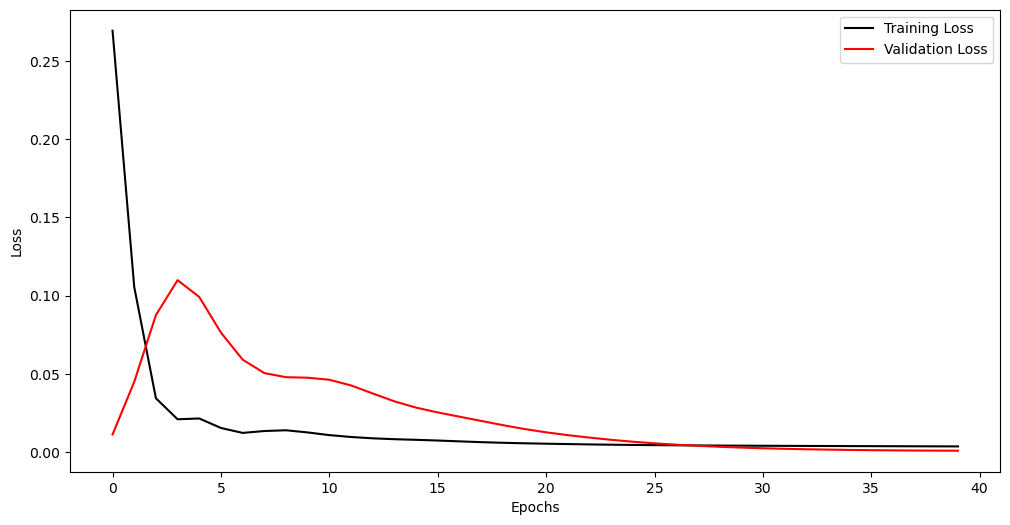

1/1 [==============================] - 0s 21ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3129 - val_loss: 0.0061 - 2s/epoch - 304ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1228 - val_loss: 0.0351 - 45ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0373 - val_loss: 0.0769 - 45ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0229 - val_loss: 0.0978 - 40ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0237 - val_loss: 0.0838 - 42ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0150 - val_loss: 0.0603 - 39ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0118 - val_loss: 0.0445 - 39ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0135 - val_loss: 0.0374 - 39ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0134 - val_loss: 0.0355 - 43ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0113 - val_loss: 0.0348 - 40ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0094 - val_loss: 0.0322 - 43ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0082 - val_loss: 0.0275 - 40ms/epoch - 7ms/step
Epoch 13/

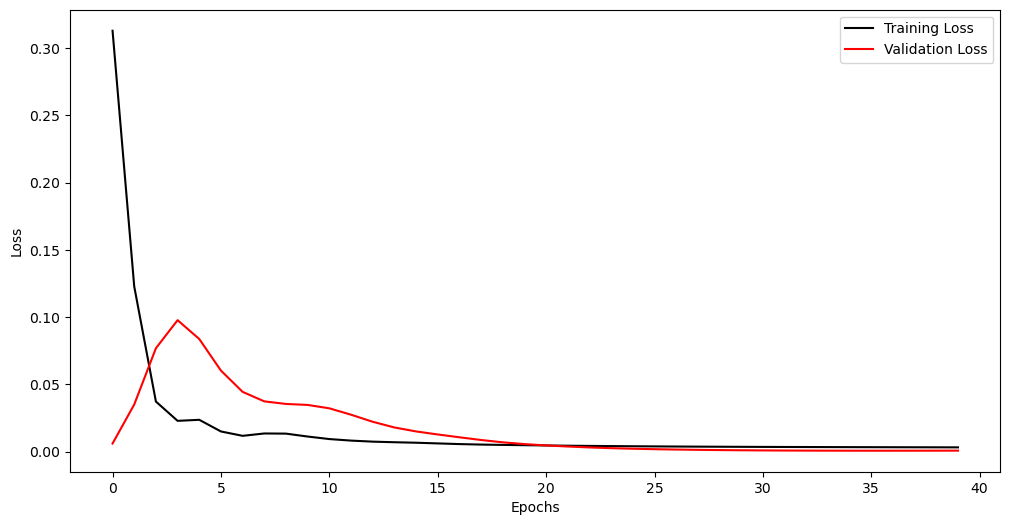

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.2889 - val_loss: 0.0433 - 2s/epoch - 313ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1237 - val_loss: 0.1010 - 51ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0494 - val_loss: 0.1605 - 50ms/epoch - 8ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0324 - val_loss: 0.1832 - 39ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0287 - val_loss: 0.1612 - 39ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0210 - val_loss: 0.1259 - 38ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0174 - val_loss: 0.0989 - 39ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0179 - val_loss: 0.0837 - 42ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0176 - val_loss: 0.0765 - 53ms/epoch - 9ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0155 - val_loss: 0.0724 - 56ms/epoch - 9ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0130 - val_loss: 0.0675 - 44ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0112 - val_loss: 0.0601 - 43ms/epoch - 7ms/step
Epoch 13/

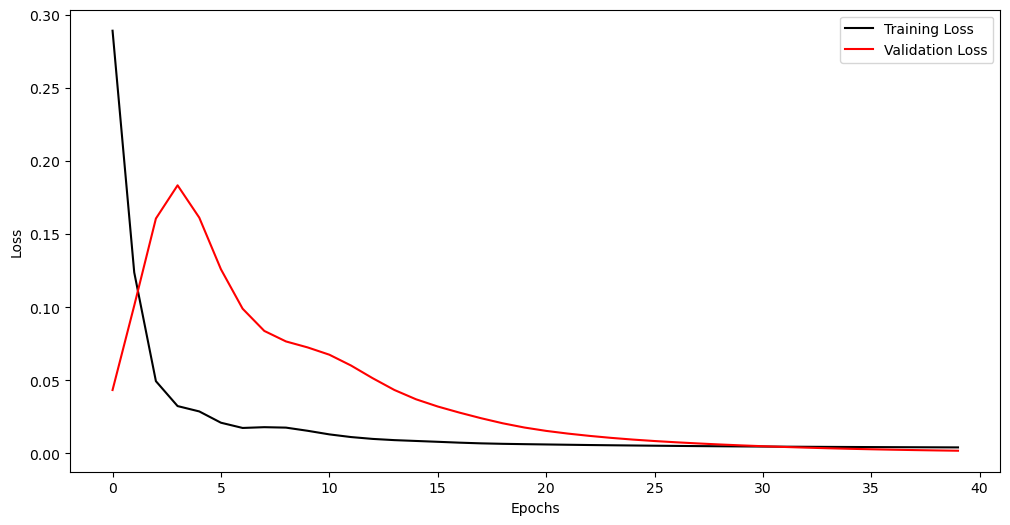

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 3s - loss: 0.2913 - val_loss: 0.0043 - 3s/epoch - 441ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1307 - val_loss: 0.0168 - 48ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0464 - val_loss: 0.0483 - 43ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0244 - val_loss: 0.0737 - 46ms/epoch - 8ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0273 - val_loss: 0.0701 - 43ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0222 - val_loss: 0.0526 - 42ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0176 - val_loss: 0.0391 - 46ms/epoch - 8ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0178 - val_loss: 0.0327 - 45ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0179 - val_loss: 0.0313 - 47ms/epoch - 8ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0163 - val_loss: 0.0320 - 41ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0144 - val_loss: 0.0321 - 42ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0131 - val_loss: 0.0302 - 38ms/epoch - 6ms/step
Epoch 13/

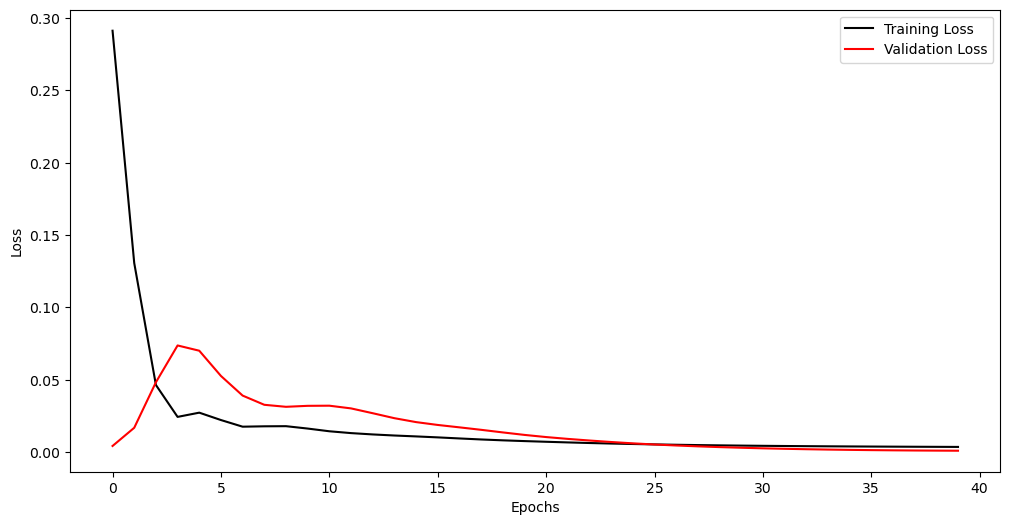

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.4808 - val_loss: 0.0099 - 2s/epoch - 320ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2362 - val_loss: 0.0451 - 46ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0993 - val_loss: 0.0988 - 44ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0383 - val_loss: 0.1533 - 40ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0272 - val_loss: 0.1785 - 42ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0277 - val_loss: 0.1654 - 39ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0225 - val_loss: 0.1367 - 43ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0191 - val_loss: 0.1124 - 43ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0198 - val_loss: 0.0979 - 39ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0207 - val_loss: 0.0915 - 43ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0199 - val_loss: 0.0893 - 41ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0182 - val_loss: 0.0875 - 57ms/epoch - 10ms/step
Epoch 13

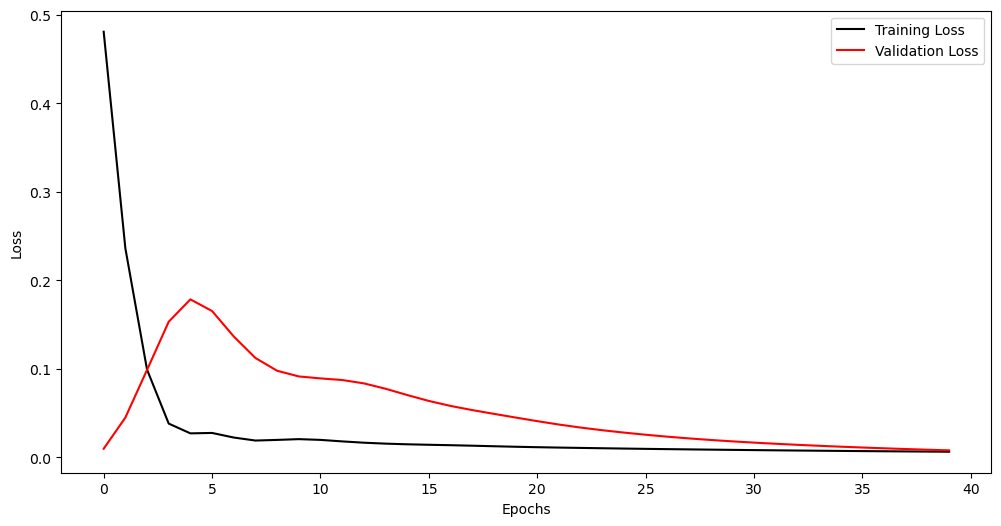

1/1 [==============================] - 0s 21ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3458 - val_loss: 0.0014 - 2s/epoch - 314ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1433 - val_loss: 0.0195 - 47ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0437 - val_loss: 0.0529 - 50ms/epoch - 8ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0134 - val_loss: 0.0814 - 42ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0160 - val_loss: 0.0842 - 39ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0147 - val_loss: 0.0679 - 43ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0097 - val_loss: 0.0511 - 47ms/epoch - 8ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0096 - val_loss: 0.0410 - 62ms/epoch - 10ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0110 - val_loss: 0.0370 - 61ms/epoch - 10ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0106 - val_loss: 0.0364 - 44ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0091 - val_loss: 0.0362 - 80ms/epoch - 13ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0081 - val_loss: 0.0345 - 58ms/epoch - 10ms/step
Epoch

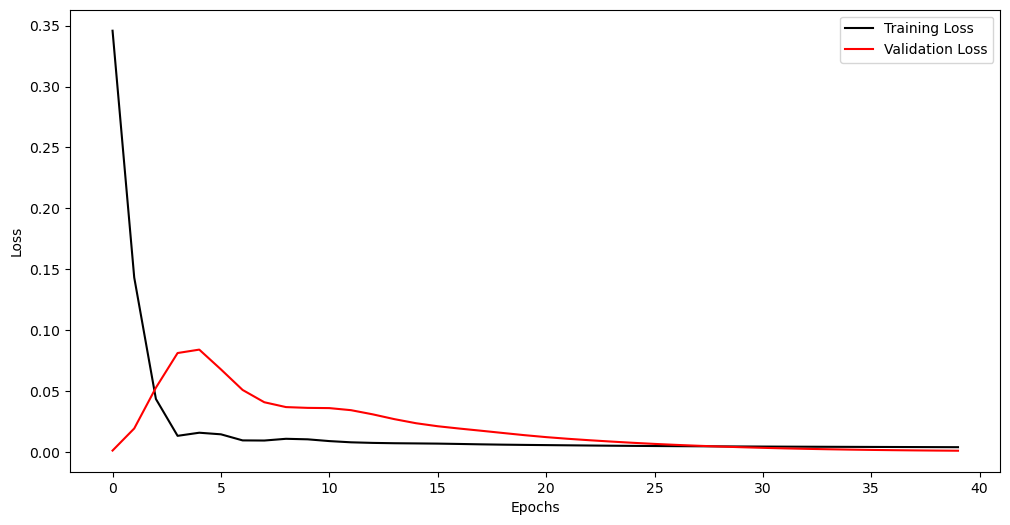

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3545 - val_loss: 0.0019 - 2s/epoch - 290ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1524 - val_loss: 0.0227 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0490 - val_loss: 0.0611 - 41ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0156 - val_loss: 0.0952 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0173 - val_loss: 0.0994 - 36ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0157 - val_loss: 0.0805 - 36ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0105 - val_loss: 0.0608 - 36ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0105 - val_loss: 0.0492 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0121 - val_loss: 0.0448 - 42ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0117 - val_loss: 0.0443 - 46ms/epoch - 8ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0102 - val_loss: 0.0443 - 37ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0092 - val_loss: 0.0426 - 37ms/epoch - 6ms/step
Epoch 13/

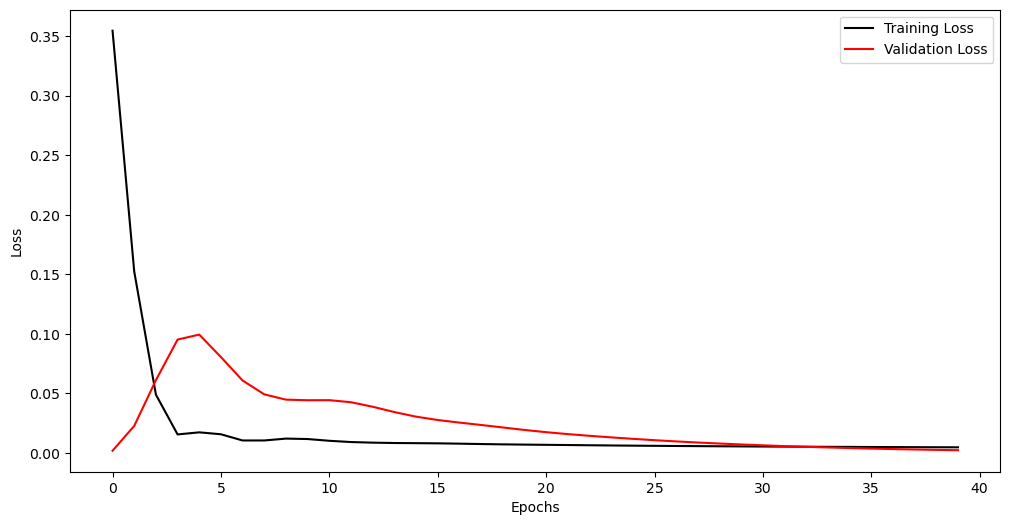

1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3202 - val_loss: 0.0113 - 2s/epoch - 304ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1537 - val_loss: 0.0426 - 43ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0620 - val_loss: 0.0882 - 41ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0253 - val_loss: 0.1296 - 38ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0219 - val_loss: 0.1401 - 37ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0206 - val_loss: 0.1218 - 36ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0160 - val_loss: 0.0981 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0151 - val_loss: 0.0819 - 39ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0162 - val_loss: 0.0740 - 36ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0161 - val_loss: 0.0713 - 36ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0147 - val_loss: 0.0702 - 36ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0133 - val_loss: 0.0679 - 36ms/epoch - 6ms/step
Epoch 13/

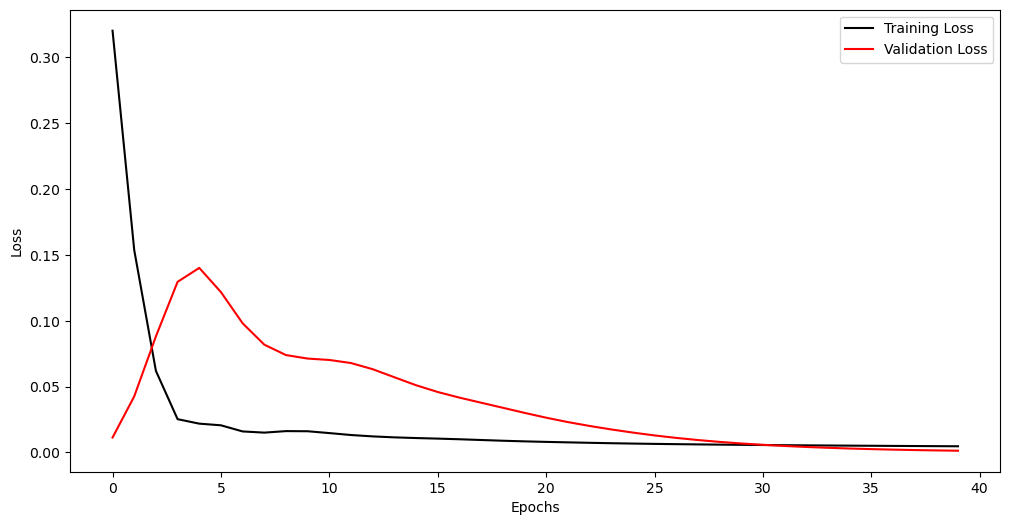

1/1 [==============================] - 0s 22ms/step
Epoch 1/40
6/6 - 2s - loss: 0.2280 - val_loss: 0.0298 - 2s/epoch - 314ms/step
Epoch 2/40
6/6 - 0s - loss: 0.0751 - val_loss: 0.0766 - 45ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0207 - val_loss: 0.1198 - 43ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0196 - val_loss: 0.1209 - 38ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0158 - val_loss: 0.0926 - 41ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0098 - val_loss: 0.0679 - 38ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0114 - val_loss: 0.0555 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0126 - val_loss: 0.0519 - 40ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0108 - val_loss: 0.0514 - 39ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0089 - val_loss: 0.0490 - 39ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0080 - val_loss: 0.0432 - 38ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0075 - val_loss: 0.0362 - 37ms/epoch - 6ms/step
Epoch 13/

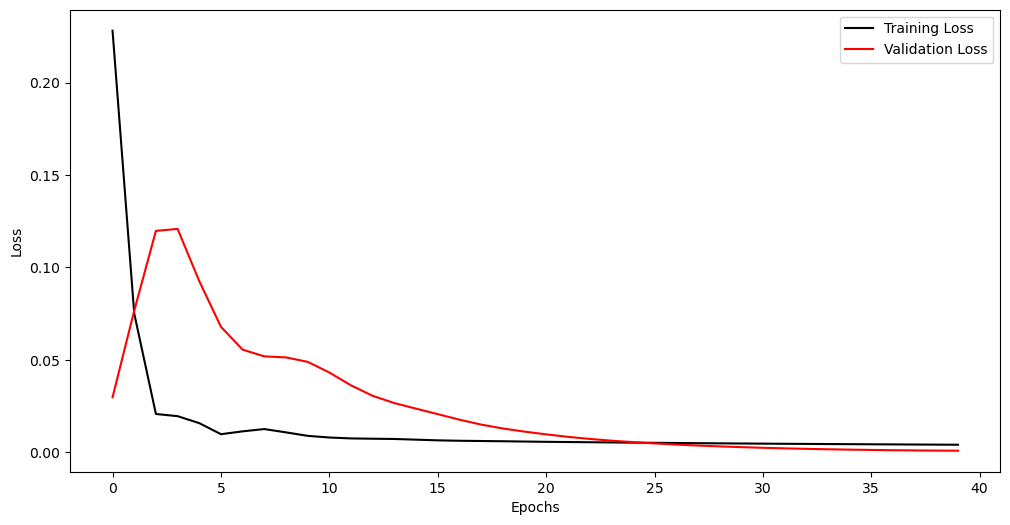

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3730 - val_loss: 0.0028 - 2s/epoch - 307ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1659 - val_loss: 0.0184 - 45ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0562 - val_loss: 0.0522 - 45ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0228 - val_loss: 0.0816 - 39ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0263 - val_loss: 0.0806 - 39ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0220 - val_loss: 0.0613 - 41ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0159 - val_loss: 0.0448 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0163 - val_loss: 0.0363 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0172 - val_loss: 0.0338 - 40ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0158 - val_loss: 0.0340 - 40ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0140 - val_loss: 0.0340 - 40ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0128 - val_loss: 0.0320 - 40ms/epoch - 7ms/step
Epoch 13/

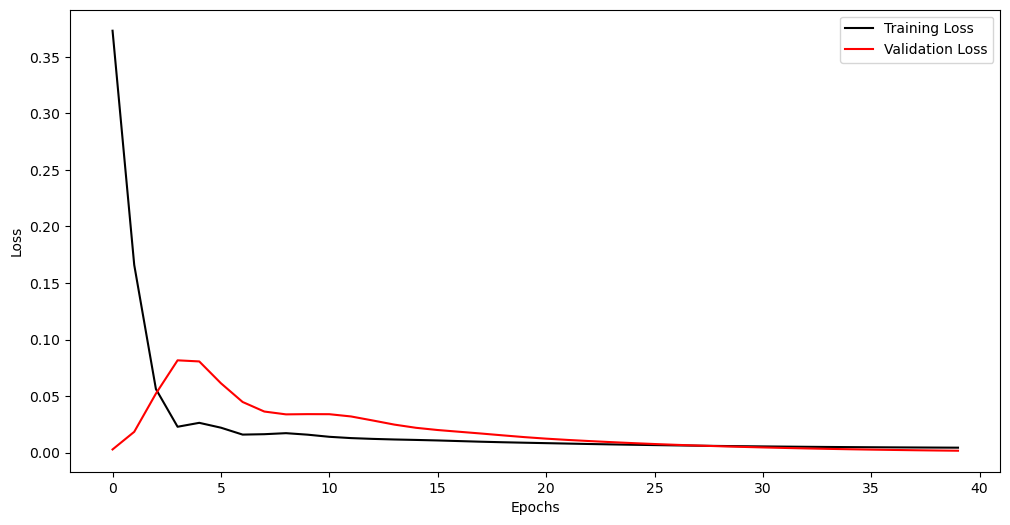

1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.2025 - val_loss: 0.0222 - 2s/epoch - 296ms/step
Epoch 2/40
6/6 - 0s - loss: 0.0586 - val_loss: 0.0593 - 47ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0183 - val_loss: 0.0884 - 48ms/epoch - 8ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0201 - val_loss: 0.0853 - 40ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0152 - val_loss: 0.0645 - 40ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0099 - val_loss: 0.0470 - 40ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0112 - val_loss: 0.0383 - 39ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0121 - val_loss: 0.0357 - 39ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0105 - val_loss: 0.0353 - 39ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0088 - val_loss: 0.0335 - 43ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0079 - val_loss: 0.0295 - 39ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0073 - val_loss: 0.0245 - 41ms/epoch - 7ms/step
Epoch 13/

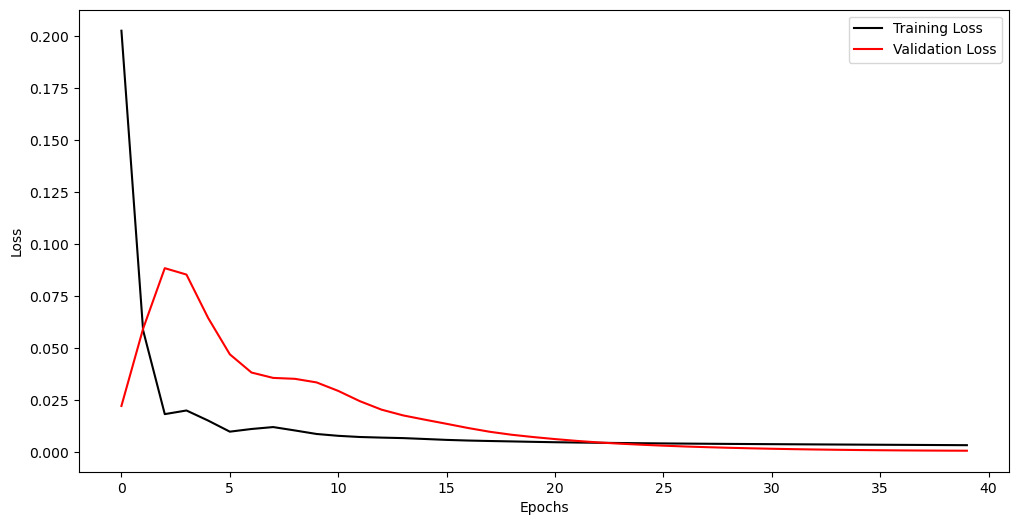

1/1 [==============================] - 0s 21ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3558 - val_loss: 0.0057 - 2s/epoch - 304ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1526 - val_loss: 0.0361 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0503 - val_loss: 0.0847 - 44ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0237 - val_loss: 0.1175 - 39ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0249 - val_loss: 0.1083 - 37ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0177 - val_loss: 0.0802 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0126 - val_loss: 0.0583 - 38ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0138 - val_loss: 0.0471 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0146 - val_loss: 0.0432 - 36ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0130 - val_loss: 0.0421 - 36ms/epoch - 6ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0109 - val_loss: 0.0401 - 38ms/epoch - 6ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0095 - val_loss: 0.0356 - 40ms/epoch - 7ms/step
Epoch 13/

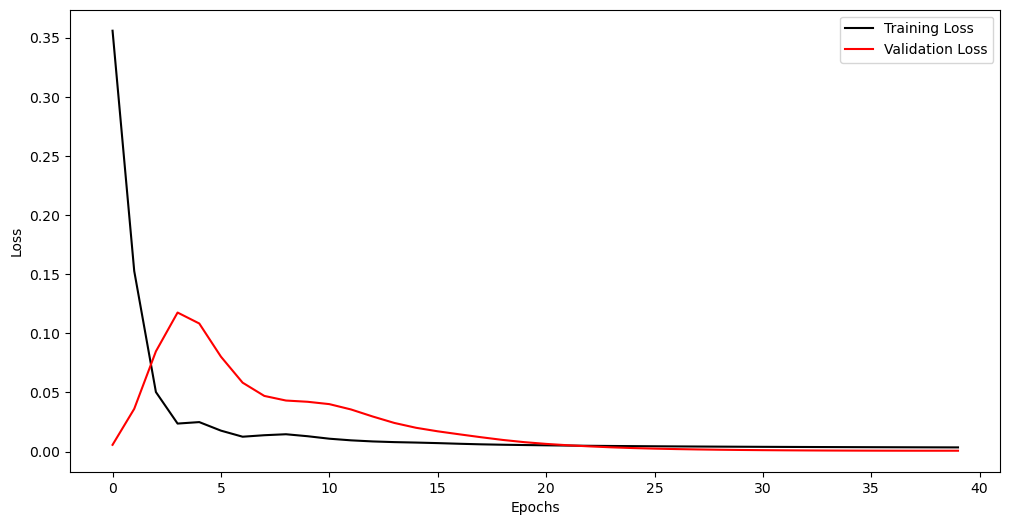

1/1 [==============================] - 0s 19ms/step


In [15]:
results = []
# run_loop(learnin rate, num_units, dropout_rate, batch_size, loop, num_epochs):
run_loop(0.001, 50, 0.0, 16, 40, 40)

In [16]:
#print(results)

best_index = 0
best_score = results[0][1]['nse_test']
for i in range(len(results)):
    if (results[i][1]['nse_test'] > best_score):
        best_score = results[i][1]['nse_test']
        best_index = i
        
        
#print(best_index, best_score)

In [17]:
# Get the best model metrics
best_metrics = results[best_index][1]
best_time = best_metrics['elapsed_time']

print(f"Best Model Index: {best_index}")
print(f"Convergence Time: {best_time:.4f} seconds")


print(f"Training MAPE: {best_metrics['mape_train']:.4f}")
print(f"Training RMSE: {best_metrics['rmse_train']:.4f}")
print(f"Training NSE: {best_metrics['nse_train']:.4f}")
print('\n')
print(f"Testing MAPE: {best_metrics['mape_test']:.4f}")
print(f"Testing RMSE: {best_metrics['rmse_test']:.4f}")
print(f"Testing NSE: {best_metrics['nse_test']:.4f}")


Best Model Index: 7
Convergence Time: 4.1038 seconds
Training MAPE: 0.4150
Training RMSE: 0.0805
Training NSE: 0.9353


Testing MAPE: 0.2019
Testing RMSE: 0.0372
Testing NSE: 0.4977


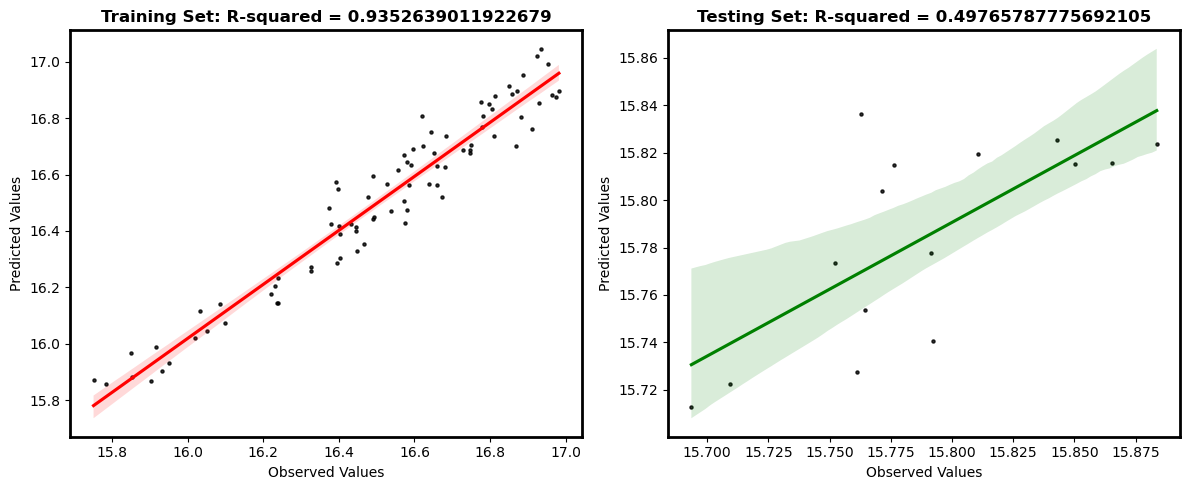

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Plot the observed vs. predicted values for the training set
plt.subplot(1, 2, 1)
sns.regplot(x=results[best_index][1]['y_train_original'], y=results[best_index][1]['train_pred_original'], color='black', scatter_kws={'s':5}, line_kws={'color':'red'})
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
title = results[best_index][1]['nse_train']
plt.title(f'Training Set: R-squared = {title}', fontweight='bold')

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Plot the observed vs. predicted values for the testing set
plt.subplot(1, 2, 2)
sns.regplot(x=results[best_index][1]['y_test_original'], y=results[best_index][1]['test_pred_original'], color='black', scatter_kws={'s':5}, line_kws={'color':'green'})
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
title = results[best_index][1]['nse_test']
plt.title(f'Testing Set: NSE = {title}', fontweight='bold')

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
#plt.savefig("01_Hybrid_model_fit_diagram.png", dpi=300)

plt.show()


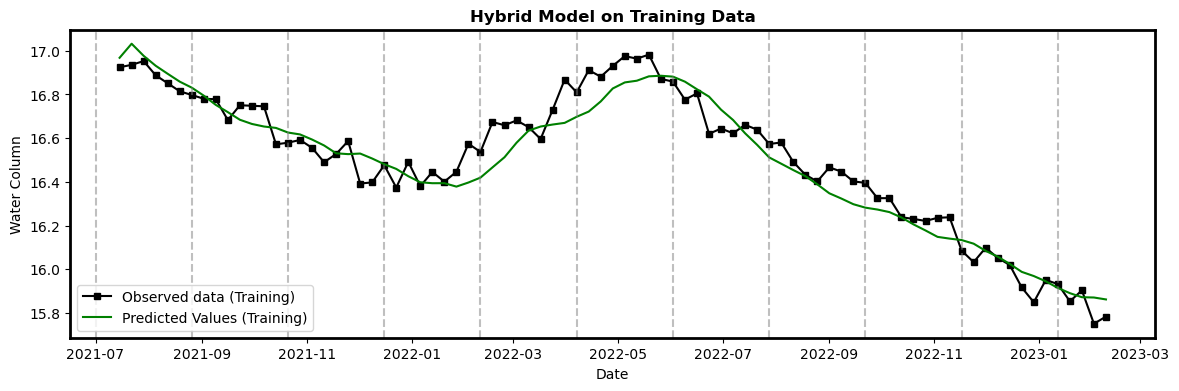

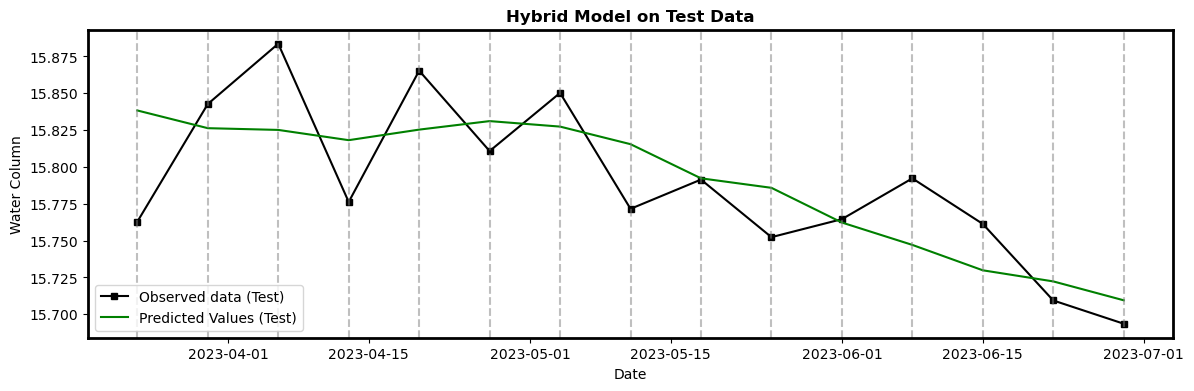

In [35]:
# First Plot for Training Data
plt.figure(figsize=(14, 4))

# Plot the predicted values for the training set
plt.plot(features_df.index[:split_index], results[best_index][1]['y_train_original'], label='Observed data (Training)', marker='s', markersize =4, color = 'black')

# Plot the predicted values for the training set
plt.plot(features_df.index[:split_index], results[best_index][1]['train_pred_original'], label='Predicted Values (Training)', color='green', linestyle='solid')

# Add vertical lines for each 8 weeks
current_date = pd.Timestamp('2021-07-01')
end_date = features_df.index[split_index]
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=8)

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.xlabel('Date')
plt.ylabel('Water Column')
plt.title('Hybrid Model on Training Data', fontweight='bold')
plt.legend(loc='lower left')
#plt.savefig("02_Hybrid_model_forecast_diagram.png", dpi=300)


plt.show()

# Second Plot for Test Data
plt.figure(figsize=(14, 4))

# Plot the predicted values for the testing set
plt.plot(features_df.index[split_index+look_back:], results[best_index][1]['y_test_original'], label='Observed data (Test)', marker='s', markersize =4, color = 'black')

# Plot the predicted values for the testing set
plt.plot(features_df.index[split_index+look_back:], results[best_index][1]['test_pred_original'], label='Predicted Values (Test)', color='g', linestyle='solid')

# Add vertical lines for each 8 weeks
current_date = features_df.index[split_index+look_back]
end_date = pd.Timestamp('2023-07-01')
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=1)
    

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.xlabel('Date')
plt.ylabel('Water Column')
plt.title('Hybrid Model on Test Data', fontweight='bold')
plt.legend(loc='lower left')
#plt.savefig("03_Hybrid_model_forecast_diagram.png", dpi=300)


plt.show()


## Fine Tuning 



### Dropout Regularization

In [20]:
hybrid_data = convert_to_datetime(lstm_data)


# Fit an ARIMA model to the data
model = ARIMA(hybrid_data["Water Column"], order=(1,1,5))
fit = model.fit()

# Add ARIMA components to a new dataframe
features_df = pd.DataFrame(index=hybrid_data.index)
features_df["Date"] = hybrid_data['Date']
features_df["Water Column"] = hybrid_data["Water Column"]
features_df["Water Temperature"] = hybrid_data["Water Temperature"]
features_df["degree_C Soil Temperature"] = hybrid_data["degree_C Soil Temperature"]
features_df["mS/cm Saturation Extract EC"] = hybrid_data["mS/cm Saturation Extract EC"]

#features_df["trend"] = fit.fittedvalues
features_df["residual"] = fit.resid
#features_df["seasonal"] = hybrid_data["Water Column"] - features_df["trend"] - features_df["residual"]





#View the data along with ARIMA residuals included
# # Set the Date as the index
features_df.set_index('Date', inplace=True)
features_df.head(5)


,Water Column,Water Temperature,degree_C Soil Temperature,mS/cm Saturation Extract EC,residual
Date,,,,,
2021-07-15,17.081110,15.201198,21.235897,0.540231,17.081110
2021-07-22,17.083686,15.200632,20.881845,0.556539,0.002575
2021-07-29,17.082886,15.200722,21.578720,0.519045,-0.000224
2021-08-05,17.032243,15.198781,22.060417,0.497743,-0.050852
2021-08-12,16.995771,15.197786,22.123363,0.491604,-0.047510


In [21]:
# Scale the selected data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features_df)

In [22]:
# Setting the random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the lookback period
look_back = 5

# Reshape the data into sequences with a lookback period of 5
def create_sequences(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back):
        a = data[i:(i+look_back), :]
        X.append(a)
        Y.append(data[i+look_back, 0])  # Predict the next water level
    return np.array(X), np.array(Y)

X, y = create_sequences(scaled_data, look_back)

In [23]:
# Split the reshaped data into training and testing datasets
split_index = int(0.85 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Print the shape of the reshaped data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (83, 5, 5)
Shape of y_train: (83,)
Shape of X_test: (15, 5, 5)
Shape of y_test: (15,)


In [25]:
def run_loop(learning_rate, num_units, dropout_rate, batch_size, loop, num_epochs):
    for i in range(loop):
        
        # Start time capture
        start_time = time.time()
        
        # Define the LSTM model
        model = Sequential()
        # Add the first LSTM layer
        model.add(LSTM(num_units, input_shape=(look_back, 5), kernel_initializer='glorot_uniform'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, kernel_initializer='glorot_uniform'))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Train the model with validation data set to the test set
        history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, shuffle=False, verbose=2, validation_data=(X_test, y_test))

        # Display the model summary
        model.summary()

        # Evaluate the model on the validation data
        validation_loss = model.evaluate(X_test, y_test)
        print(f"Validation Loss: {validation_loss}")


        # Use the trained model to make predictions on the training and validation data
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)


        # Reshape the data to inverse transform
        train_pred_reshaped = np.zeros((len(train_pred), X_train.shape[2]))
        train_pred_reshaped[:,0] = train_pred[:,0].reshape(-1)
        test_pred_reshaped = np.zeros((len(test_pred), X_test.shape[2]))
        test_pred_reshaped[:,0] = test_pred[:,0].reshape(-1)

        # Inverse transform the predictions
        train_pred_original = scaler.inverse_transform(train_pred_reshaped)[:,0]
        test_pred_original = scaler.inverse_transform(test_pred_reshaped)[:,0]

        # Inverse transform the target values
        y_train_original = scaler.inverse_transform(np.hstack((y_train.reshape(-1,1), np.zeros((y_train.shape[0], X_train.shape[2]-1)))))[:,0]
        y_test_original = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1), np.zeros((y_test.shape[0], X_test.shape[2]-1)))))[:,0]

        # Calculate the performance metrics
        mape_train = mean_absolute_percentage_error(y_train_original, train_pred_original)
        rmse_train = np.sqrt(mean_squared_error(y_train_original, train_pred_original))
        nse_train = nash_sutcliffe_efficiency(y_train_original, train_pred_original)

        mape_test = mean_absolute_percentage_error(y_test_original, test_pred_original)
        rmse_test = np.sqrt(mean_squared_error(y_test_original, test_pred_original))
        nse_test = nash_sutcliffe_efficiency(y_test_original, test_pred_original)
        
        # End time capture
        end_time = time.time()
        # Calculate elapsed time
        elapsed_time = end_time - start_time

        results.append((model, {"train_pred_original": train_pred_original, "test_pred_original": test_pred_original, "y_train_original": y_train_original, "y_test_original": y_test_original, "mape_train": mape_train, "rmse_train": rmse_train, "nse_train": nse_train, "mape_test": mape_test, "rmse_test": rmse_test, "nse_test": nse_test, "elapsed_time": elapsed_time}))
        
        

## Executing the model with 100 Iteration

In [29]:
results = []
# run_loop(learnin rate, num_units, dropout_rate, batch_size, loop, num_epochs):
run_loop(0.001, 50, 0.4, 16, 40, 50)

Epoch 1/50
6/6 - 2s - loss: 0.5359 - val_loss: 0.0014 - 2s/epoch - 317ms/step
Epoch 2/50
6/6 - 0s - loss: 0.3041 - val_loss: 0.0090 - 48ms/epoch - 8ms/step
Epoch 3/50
6/6 - 0s - loss: 0.1407 - val_loss: 0.0372 - 48ms/epoch - 8ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0536 - val_loss: 0.0773 - 40ms/epoch - 7ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0382 - val_loss: 0.1044 - 40ms/epoch - 7ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0408 - val_loss: 0.1010 - 43ms/epoch - 7ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0204 - val_loss: 0.0810 - 42ms/epoch - 7ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0280 - val_loss: 0.0640 - 41ms/epoch - 7ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0345 - val_loss: 0.0521 - 41ms/epoch - 7ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0265 - val_loss: 0.0474 - 40ms/epoch - 7ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0300 - val_loss: 0.0455 - 40ms/epoch - 7ms/step
Epoch 12/50
6/6 - 0s - loss: 0.0278 - val_loss: 0.0456 - 40ms/epoch - 7ms/step
Epoch 13/50
6/6 - 0s - loss: 0.0263 - val_loss: 0.0479 - 39ms

Epoch 42/50
6/6 - 0s - loss: 0.0113 - val_loss: 0.0051 - 38ms/epoch - 6ms/step
Epoch 43/50
6/6 - 0s - loss: 0.0121 - val_loss: 0.0045 - 39ms/epoch - 6ms/step
Epoch 44/50
6/6 - 0s - loss: 0.0115 - val_loss: 0.0032 - 38ms/epoch - 6ms/step
Epoch 45/50
6/6 - 0s - loss: 0.0097 - val_loss: 0.0026 - 39ms/epoch - 6ms/step
Epoch 46/50
6/6 - 0s - loss: 0.0113 - val_loss: 0.0030 - 54ms/epoch - 9ms/step
Epoch 47/50
6/6 - 0s - loss: 0.0132 - val_loss: 0.0028 - 40ms/epoch - 7ms/step
Epoch 48/50
6/6 - 0s - loss: 0.0132 - val_loss: 0.0025 - 36ms/epoch - 6ms/step
Epoch 49/50
6/6 - 0s - loss: 0.0133 - val_loss: 0.0023 - 36ms/epoch - 6ms/step
Epoch 50/50
6/6 - 0s - loss: 0.0088 - val_loss: 0.0021 - 36ms/epoch - 6ms/step
Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_111 (LSTM)             (None, 50)                11200     
                                                                 
 

Epoch 20/50
6/6 - 0s - loss: 0.0222 - val_loss: 0.0210 - 36ms/epoch - 6ms/step
Epoch 21/50
6/6 - 0s - loss: 0.0156 - val_loss: 0.0201 - 36ms/epoch - 6ms/step
Epoch 22/50
6/6 - 0s - loss: 0.0149 - val_loss: 0.0203 - 37ms/epoch - 6ms/step
Epoch 23/50
6/6 - 0s - loss: 0.0184 - val_loss: 0.0190 - 36ms/epoch - 6ms/step
Epoch 24/50
6/6 - 0s - loss: 0.0169 - val_loss: 0.0163 - 36ms/epoch - 6ms/step
Epoch 25/50
6/6 - 0s - loss: 0.0177 - val_loss: 0.0149 - 36ms/epoch - 6ms/step
Epoch 26/50
6/6 - 0s - loss: 0.0167 - val_loss: 0.0128 - 36ms/epoch - 6ms/step
Epoch 27/50
6/6 - 0s - loss: 0.0150 - val_loss: 0.0131 - 36ms/epoch - 6ms/step
Epoch 28/50
6/6 - 0s - loss: 0.0214 - val_loss: 0.0153 - 36ms/epoch - 6ms/step
Epoch 29/50
6/6 - 0s - loss: 0.0135 - val_loss: 0.0146 - 36ms/epoch - 6ms/step
Epoch 30/50
6/6 - 0s - loss: 0.0158 - val_loss: 0.0116 - 36ms/epoch - 6ms/step
Epoch 31/50
6/6 - 0s - loss: 0.0136 - val_loss: 0.0110 - 38ms/epoch - 6ms/step
Epoch 32/50
6/6 - 0s - loss: 0.0197 - val_loss: 0.01

1/1 [==============================] - 0s 22ms/step - loss: 0.0014
Validation Loss: 0.0014257726725190878
1/1 [==============================] - 0s 20ms/step
Epoch 1/50
6/6 - 2s - loss: 0.2257 - val_loss: 0.0321 - 2s/epoch - 297ms/step
Epoch 2/50
6/6 - 0s - loss: 0.0997 - val_loss: 0.0731 - 43ms/epoch - 7ms/step
Epoch 3/50
6/6 - 0s - loss: 0.0506 - val_loss: 0.1110 - 42ms/epoch - 7ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0336 - val_loss: 0.1226 - 37ms/epoch - 6ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0376 - val_loss: 0.1107 - 37ms/epoch - 6ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0328 - val_loss: 0.0943 - 37ms/epoch - 6ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0300 - val_loss: 0.0818 - 36ms/epoch - 6ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0337 - val_loss: 0.0728 - 37ms/epoch - 6ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0342 - val_loss: 0.0660 - 37ms/epoch - 6ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0279 - val_loss: 0.0633 - 37ms/epoch - 6ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0264 - val_loss: 0.0604 - 37ms

Epoch 40/50
6/6 - 0s - loss: 0.0109 - val_loss: 0.0021 - 36ms/epoch - 6ms/step
Epoch 41/50
6/6 - 0s - loss: 0.0164 - val_loss: 0.0022 - 36ms/epoch - 6ms/step
Epoch 42/50
6/6 - 0s - loss: 0.0093 - val_loss: 0.0028 - 36ms/epoch - 6ms/step
Epoch 43/50
6/6 - 0s - loss: 0.0104 - val_loss: 0.0022 - 36ms/epoch - 6ms/step
Epoch 44/50
6/6 - 0s - loss: 0.0108 - val_loss: 0.0017 - 36ms/epoch - 6ms/step
Epoch 45/50
6/6 - 0s - loss: 0.0089 - val_loss: 0.0015 - 36ms/epoch - 6ms/step
Epoch 46/50
6/6 - 0s - loss: 0.0127 - val_loss: 0.0015 - 36ms/epoch - 6ms/step
Epoch 47/50
6/6 - 0s - loss: 0.0113 - val_loss: 0.0013 - 37ms/epoch - 6ms/step
Epoch 48/50
6/6 - 0s - loss: 0.0124 - val_loss: 0.0016 - 36ms/epoch - 6ms/step
Epoch 49/50
6/6 - 0s - loss: 0.0097 - val_loss: 0.0017 - 36ms/epoch - 6ms/step
Epoch 50/50
6/6 - 0s - loss: 0.0093 - val_loss: 0.0012 - 36ms/epoch - 6ms/step
Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape

Epoch 18/50
6/6 - 0s - loss: 0.0137 - val_loss: 0.0097 - 36ms/epoch - 6ms/step
Epoch 19/50
6/6 - 0s - loss: 0.0204 - val_loss: 0.0087 - 37ms/epoch - 6ms/step
Epoch 20/50
6/6 - 0s - loss: 0.0155 - val_loss: 0.0088 - 39ms/epoch - 7ms/step
Epoch 21/50
6/6 - 0s - loss: 0.0189 - val_loss: 0.0103 - 37ms/epoch - 6ms/step
Epoch 22/50
6/6 - 0s - loss: 0.0127 - val_loss: 0.0083 - 38ms/epoch - 6ms/step
Epoch 23/50
6/6 - 0s - loss: 0.0162 - val_loss: 0.0057 - 38ms/epoch - 6ms/step
Epoch 24/50
6/6 - 0s - loss: 0.0156 - val_loss: 0.0049 - 38ms/epoch - 6ms/step
Epoch 25/50
6/6 - 0s - loss: 0.0122 - val_loss: 0.0051 - 38ms/epoch - 6ms/step
Epoch 26/50
6/6 - 0s - loss: 0.0148 - val_loss: 0.0037 - 39ms/epoch - 6ms/step
Epoch 27/50
6/6 - 0s - loss: 0.0116 - val_loss: 0.0042 - 38ms/epoch - 6ms/step
Epoch 28/50
6/6 - 0s - loss: 0.0149 - val_loss: 0.0048 - 38ms/epoch - 6ms/step
Epoch 29/50
6/6 - 0s - loss: 0.0148 - val_loss: 0.0030 - 38ms/epoch - 6ms/step
Epoch 30/50
6/6 - 0s - loss: 0.0132 - val_loss: 0.00

                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 23ms/step - loss: 9.5558e-04
Validation Loss: 0.000955579977016896
1/1 [==============================] - 0s 20ms/step
Epoch 1/50
6/6 - 2s - loss: 0.4145 - val_loss: 0.0023 - 2s/epoch - 290ms/step
Epoch 2/50
6/6 - 0s - loss: 0.2187 - val_loss: 0.0076 - 47ms/epoch - 8ms/step
Epoch 3/50
6/6 - 0s - loss: 0.0941 - val_loss: 0.0272 - 45ms/epoch - 7ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0445 - val_loss: 0.0539 - 40ms/epoch - 7ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0422 - val_loss: 0.0693 - 38ms/epoch - 6ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0367 - val_loss: 0.0678 - 44ms/epoch - 7ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0248 - val_loss: 0.0541 - 43ms/epoch - 7ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0326 - val_loss: 0.0444 - 45ms/epoch - 8ms/step
Epoch 9/50
6/

Epoch 36/50
6/6 - 0s - loss: 0.0127 - val_loss: 0.0015 - 36ms/epoch - 6ms/step
Epoch 37/50
6/6 - 0s - loss: 0.0132 - val_loss: 0.0018 - 36ms/epoch - 6ms/step
Epoch 38/50
6/6 - 0s - loss: 0.0149 - val_loss: 0.0019 - 36ms/epoch - 6ms/step
Epoch 39/50
6/6 - 0s - loss: 0.0149 - val_loss: 0.0011 - 36ms/epoch - 6ms/step
Epoch 40/50
6/6 - 0s - loss: 0.0093 - val_loss: 9.3241e-04 - 36ms/epoch - 6ms/step
Epoch 41/50
6/6 - 0s - loss: 0.0166 - val_loss: 0.0013 - 36ms/epoch - 6ms/step
Epoch 42/50
6/6 - 0s - loss: 0.0117 - val_loss: 0.0023 - 36ms/epoch - 6ms/step
Epoch 43/50
6/6 - 0s - loss: 0.0116 - val_loss: 0.0015 - 36ms/epoch - 6ms/step
Epoch 44/50
6/6 - 0s - loss: 0.0127 - val_loss: 0.0012 - 37ms/epoch - 6ms/step
Epoch 45/50
6/6 - 0s - loss: 0.0087 - val_loss: 9.2172e-04 - 37ms/epoch - 6ms/step
Epoch 46/50
6/6 - 0s - loss: 0.0101 - val_loss: 0.0010 - 36ms/epoch - 6ms/step
Epoch 47/50
6/6 - 0s - loss: 0.0122 - val_loss: 7.7422e-04 - 36ms/epoch - 6ms/step
Epoch 48/50
6/6 - 0s - loss: 0.0136 - va

6/6 - 0s - loss: 0.0261 - val_loss: 0.0195 - 37ms/epoch - 6ms/step
Epoch 14/50
6/6 - 0s - loss: 0.0203 - val_loss: 0.0216 - 36ms/epoch - 6ms/step
Epoch 15/50
6/6 - 0s - loss: 0.0247 - val_loss: 0.0222 - 37ms/epoch - 6ms/step
Epoch 16/50
6/6 - 0s - loss: 0.0233 - val_loss: 0.0194 - 36ms/epoch - 6ms/step
Epoch 17/50
6/6 - 0s - loss: 0.0312 - val_loss: 0.0196 - 37ms/epoch - 6ms/step
Epoch 18/50
6/6 - 0s - loss: 0.0155 - val_loss: 0.0187 - 37ms/epoch - 6ms/step
Epoch 19/50
6/6 - 0s - loss: 0.0210 - val_loss: 0.0200 - 37ms/epoch - 6ms/step
Epoch 20/50
6/6 - 0s - loss: 0.0229 - val_loss: 0.0177 - 37ms/epoch - 6ms/step
Epoch 21/50
6/6 - 0s - loss: 0.0196 - val_loss: 0.0150 - 36ms/epoch - 6ms/step
Epoch 22/50
6/6 - 0s - loss: 0.0175 - val_loss: 0.0133 - 37ms/epoch - 6ms/step
Epoch 23/50
6/6 - 0s - loss: 0.0170 - val_loss: 0.0119 - 36ms/epoch - 6ms/step
Epoch 24/50
6/6 - 0s - loss: 0.0191 - val_loss: 0.0092 - 37ms/epoch - 6ms/step
Epoch 25/50
6/6 - 0s - loss: 0.0167 - val_loss: 0.0083 - 36ms/ep

 lstm_124 (LSTM)             (None, 50)                11200     
                                                                 
 dropout_54 (Dropout)        (None, 50)                0         
                                                                 
 dense_124 (Dense)           (None, 1)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 21ms/step - loss: 8.1456e-04
Validation Loss: 0.0008145615574903786
1/1 [==============================] - 0s 20ms/step
Epoch 1/50
6/6 - 2s - loss: 0.2418 - val_loss: 0.0040 - 2s/epoch - 388ms/step
Epoch 2/50
6/6 - 0s - loss: 0.1159 - val_loss: 0.0181 - 42ms/epoch - 7ms/step
Epoch 3/50
6/6 - 0s - loss: 0.0492 - val_loss: 0.0432 - 41ms/epoch - 7ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0424 - val_loss: 0.0545 - 38ms/epoch - 6ms

Epoch 32/50
6/6 - 0s - loss: 0.0156 - val_loss: 0.0040 - 37ms/epoch - 6ms/step
Epoch 33/50
6/6 - 0s - loss: 0.0132 - val_loss: 0.0045 - 36ms/epoch - 6ms/step
Epoch 34/50
6/6 - 0s - loss: 0.0135 - val_loss: 0.0043 - 36ms/epoch - 6ms/step
Epoch 35/50
6/6 - 0s - loss: 0.0127 - val_loss: 0.0034 - 36ms/epoch - 6ms/step
Epoch 36/50
6/6 - 0s - loss: 0.0172 - val_loss: 0.0026 - 36ms/epoch - 6ms/step
Epoch 37/50
6/6 - 0s - loss: 0.0164 - val_loss: 0.0026 - 36ms/epoch - 6ms/step
Epoch 38/50
6/6 - 0s - loss: 0.0110 - val_loss: 0.0031 - 36ms/epoch - 6ms/step
Epoch 39/50
6/6 - 0s - loss: 0.0125 - val_loss: 0.0027 - 36ms/epoch - 6ms/step
Epoch 40/50
6/6 - 0s - loss: 0.0083 - val_loss: 0.0021 - 37ms/epoch - 6ms/step
Epoch 41/50
6/6 - 0s - loss: 0.0186 - val_loss: 0.0021 - 36ms/epoch - 6ms/step
Epoch 42/50
6/6 - 0s - loss: 0.0141 - val_loss: 0.0024 - 36ms/epoch - 6ms/step
Epoch 43/50
6/6 - 0s - loss: 0.0116 - val_loss: 0.0020 - 36ms/epoch - 6ms/step
Epoch 44/50
6/6 - 0s - loss: 0.0123 - val_loss: 0.00

Epoch 10/50
6/6 - 0s - loss: 0.0311 - val_loss: 0.0643 - 37ms/epoch - 6ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0312 - val_loss: 0.0592 - 37ms/epoch - 6ms/step
Epoch 12/50
6/6 - 0s - loss: 0.0315 - val_loss: 0.0564 - 36ms/epoch - 6ms/step
Epoch 13/50
6/6 - 0s - loss: 0.0332 - val_loss: 0.0534 - 36ms/epoch - 6ms/step
Epoch 14/50
6/6 - 0s - loss: 0.0235 - val_loss: 0.0471 - 37ms/epoch - 6ms/step
Epoch 15/50
6/6 - 0s - loss: 0.0267 - val_loss: 0.0409 - 37ms/epoch - 6ms/step
Epoch 16/50
6/6 - 0s - loss: 0.0277 - val_loss: 0.0355 - 37ms/epoch - 6ms/step
Epoch 17/50
6/6 - 0s - loss: 0.0292 - val_loss: 0.0332 - 36ms/epoch - 6ms/step
Epoch 18/50
6/6 - 0s - loss: 0.0254 - val_loss: 0.0321 - 37ms/epoch - 6ms/step
Epoch 19/50
6/6 - 0s - loss: 0.0213 - val_loss: 0.0284 - 38ms/epoch - 6ms/step
Epoch 20/50
6/6 - 0s - loss: 0.0231 - val_loss: 0.0232 - 38ms/epoch - 6ms/step
Epoch 21/50
6/6 - 0s - loss: 0.0198 - val_loss: 0.0203 - 38ms/epoch - 6ms/step
Epoch 22/50
6/6 - 0s - loss: 0.0221 - val_loss: 0.01

Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_129 (LSTM)             (None, 50)                11200     
                                                                 
 dropout_59 (Dropout)        (None, 50)                0         
                                                                 
 dense_129 (Dense)           (None, 1)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 21ms/step - loss: 0.0025
Validation Loss: 0.0024674064479768276
1/1 [==============================] - 0s 20ms/step
Epoch 1/50
6/6 - 2s - loss: 0.3344 - val_loss: 0.0093 - 2s/epoch - 292ms/step
Epoch 2/50
6/6 - 0s - loss: 0.1407 - val_loss: 0.0317 - 42ms/epoch - 7ms/ste

Epoch 29/50
6/6 - 0s - loss: 0.0151 - val_loss: 0.0072 - 37ms/epoch - 6ms/step
Epoch 30/50
6/6 - 0s - loss: 0.0151 - val_loss: 0.0053 - 36ms/epoch - 6ms/step
Epoch 31/50
6/6 - 0s - loss: 0.0172 - val_loss: 0.0065 - 37ms/epoch - 6ms/step
Epoch 32/50
6/6 - 1s - loss: 0.0192 - val_loss: 0.0073 - 672ms/epoch - 112ms/step
Epoch 33/50
6/6 - 0s - loss: 0.0116 - val_loss: 0.0070 - 38ms/epoch - 6ms/step
Epoch 34/50
6/6 - 0s - loss: 0.0173 - val_loss: 0.0047 - 36ms/epoch - 6ms/step
Epoch 35/50
6/6 - 0s - loss: 0.0103 - val_loss: 0.0030 - 41ms/epoch - 7ms/step
Epoch 36/50
6/6 - 0s - loss: 0.0120 - val_loss: 0.0026 - 37ms/epoch - 6ms/step
Epoch 37/50
6/6 - 0s - loss: 0.0128 - val_loss: 0.0032 - 37ms/epoch - 6ms/step
Epoch 38/50
6/6 - 0s - loss: 0.0132 - val_loss: 0.0029 - 37ms/epoch - 6ms/step
Epoch 39/50
6/6 - 0s - loss: 0.0124 - val_loss: 0.0025 - 36ms/epoch - 6ms/step
Epoch 40/50
6/6 - 0s - loss: 0.0106 - val_loss: 0.0021 - 37ms/epoch - 6ms/step
Epoch 41/50
6/6 - 0s - loss: 0.0172 - val_loss: 0

Epoch 7/50
6/6 - 0s - loss: 0.0329 - val_loss: 0.0379 - 37ms/epoch - 6ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0388 - val_loss: 0.0308 - 37ms/epoch - 6ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0328 - val_loss: 0.0276 - 37ms/epoch - 6ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0299 - val_loss: 0.0273 - 37ms/epoch - 6ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0302 - val_loss: 0.0266 - 36ms/epoch - 6ms/step
Epoch 12/50
6/6 - 0s - loss: 0.0384 - val_loss: 0.0256 - 37ms/epoch - 6ms/step
Epoch 13/50
6/6 - 0s - loss: 0.0356 - val_loss: 0.0274 - 37ms/epoch - 6ms/step
Epoch 14/50
6/6 - 0s - loss: 0.0239 - val_loss: 0.0265 - 37ms/epoch - 6ms/step
Epoch 15/50
6/6 - 0s - loss: 0.0259 - val_loss: 0.0240 - 37ms/epoch - 6ms/step
Epoch 16/50
6/6 - 0s - loss: 0.0256 - val_loss: 0.0211 - 36ms/epoch - 6ms/step
Epoch 17/50
6/6 - 0s - loss: 0.0337 - val_loss: 0.0189 - 37ms/epoch - 6ms/step
Epoch 18/50
6/6 - 0s - loss: 0.0243 - val_loss: 0.0173 - 36ms/epoch - 6ms/step
Epoch 19/50
6/6 - 0s - loss: 0.0248 - val_loss: 0.0167 

Epoch 48/50
6/6 - 0s - loss: 0.0149 - val_loss: 0.0037 - 39ms/epoch - 6ms/step
Epoch 49/50
6/6 - 0s - loss: 0.0094 - val_loss: 0.0032 - 40ms/epoch - 7ms/step
Epoch 50/50
6/6 - 0s - loss: 0.0148 - val_loss: 0.0023 - 38ms/epoch - 6ms/step
Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_134 (LSTM)             (None, 50)                11200     
                                                                 
 dropout_64 (Dropout)        (None, 50)                0         
                                                                 
 dense_134 (Dense)           (None, 1)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 23ms/step - loss: 0.0023
Validati

Epoch 26/50
6/6 - 0s - loss: 0.0205 - val_loss: 0.0100 - 40ms/epoch - 7ms/step
Epoch 27/50
6/6 - 0s - loss: 0.0120 - val_loss: 0.0084 - 38ms/epoch - 6ms/step
Epoch 28/50
6/6 - 0s - loss: 0.0236 - val_loss: 0.0088 - 38ms/epoch - 6ms/step
Epoch 29/50
6/6 - 0s - loss: 0.0166 - val_loss: 0.0096 - 38ms/epoch - 6ms/step
Epoch 30/50
6/6 - 0s - loss: 0.0180 - val_loss: 0.0076 - 39ms/epoch - 7ms/step
Epoch 31/50
6/6 - 0s - loss: 0.0141 - val_loss: 0.0069 - 38ms/epoch - 6ms/step
Epoch 32/50
6/6 - 0s - loss: 0.0209 - val_loss: 0.0060 - 38ms/epoch - 6ms/step
Epoch 33/50
6/6 - 0s - loss: 0.0139 - val_loss: 0.0062 - 38ms/epoch - 6ms/step
Epoch 34/50
6/6 - 0s - loss: 0.0152 - val_loss: 0.0049 - 38ms/epoch - 6ms/step
Epoch 35/50
6/6 - 0s - loss: 0.0150 - val_loss: 0.0034 - 38ms/epoch - 6ms/step
Epoch 36/50
6/6 - 0s - loss: 0.0181 - val_loss: 0.0029 - 37ms/epoch - 6ms/step
Epoch 37/50
6/6 - 0s - loss: 0.0168 - val_loss: 0.0036 - 39ms/epoch - 6ms/step
Epoch 38/50
6/6 - 0s - loss: 0.0126 - val_loss: 0.00

6/6 - 0s - loss: 0.0313 - val_loss: 0.0781 - 42ms/epoch - 7ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0381 - val_loss: 0.0638 - 38ms/epoch - 6ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0352 - val_loss: 0.0463 - 37ms/epoch - 6ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0343 - val_loss: 0.0380 - 37ms/epoch - 6ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0240 - val_loss: 0.0322 - 37ms/epoch - 6ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0240 - val_loss: 0.0298 - 36ms/epoch - 6ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0221 - val_loss: 0.0281 - 37ms/epoch - 6ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0174 - val_loss: 0.0263 - 37ms/epoch - 6ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0158 - val_loss: 0.0231 - 37ms/epoch - 6ms/step
Epoch 12/50
6/6 - 0s - loss: 0.0281 - val_loss: 0.0187 - 37ms/epoch - 6ms/step
Epoch 13/50
6/6 - 0s - loss: 0.0224 - val_loss: 0.0176 - 37ms/epoch - 6ms/step
Epoch 14/50
6/6 - 0s - loss: 0.0175 - val_loss: 0.0133 - 37ms/epoch - 6ms/step
Epoch 15/50
6/6 - 0s - loss: 0.0158 - val_loss: 0.0093 - 37ms/epoch - 

Epoch 44/50
6/6 - 0s - loss: 0.0125 - val_loss: 0.0021 - 36ms/epoch - 6ms/step
Epoch 45/50
6/6 - 0s - loss: 0.0091 - val_loss: 0.0022 - 36ms/epoch - 6ms/step
Epoch 46/50
6/6 - 0s - loss: 0.0107 - val_loss: 0.0022 - 36ms/epoch - 6ms/step
Epoch 47/50
6/6 - 0s - loss: 0.0115 - val_loss: 0.0017 - 36ms/epoch - 6ms/step
Epoch 48/50
6/6 - 0s - loss: 0.0129 - val_loss: 0.0014 - 36ms/epoch - 6ms/step
Epoch 49/50
6/6 - 0s - loss: 0.0134 - val_loss: 0.0017 - 37ms/epoch - 6ms/step
Epoch 50/50
6/6 - 0s - loss: 0.0081 - val_loss: 0.0014 - 36ms/epoch - 6ms/step
Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_139 (LSTM)             (None, 50)                11200     
                                                                 
 dropout_69 (Dropout)        (None, 50)                0         
                                                                 
 dense_139 (Dense)         

Epoch 22/50
6/6 - 0s - loss: 0.0208 - val_loss: 0.0167 - 36ms/epoch - 6ms/step
Epoch 23/50
6/6 - 0s - loss: 0.0190 - val_loss: 0.0164 - 36ms/epoch - 6ms/step
Epoch 24/50
6/6 - 0s - loss: 0.0204 - val_loss: 0.0129 - 36ms/epoch - 6ms/step
Epoch 25/50
6/6 - 0s - loss: 0.0191 - val_loss: 0.0090 - 36ms/epoch - 6ms/step
Epoch 26/50
6/6 - 0s - loss: 0.0160 - val_loss: 0.0066 - 36ms/epoch - 6ms/step
Epoch 27/50
6/6 - 0s - loss: 0.0162 - val_loss: 0.0064 - 36ms/epoch - 6ms/step
Epoch 28/50
6/6 - 0s - loss: 0.0225 - val_loss: 0.0079 - 36ms/epoch - 6ms/step
Epoch 29/50
6/6 - 0s - loss: 0.0153 - val_loss: 0.0072 - 36ms/epoch - 6ms/step
Epoch 30/50
6/6 - 0s - loss: 0.0160 - val_loss: 0.0047 - 36ms/epoch - 6ms/step
Epoch 31/50
6/6 - 0s - loss: 0.0179 - val_loss: 0.0043 - 36ms/epoch - 6ms/step
Epoch 32/50
6/6 - 0s - loss: 0.0184 - val_loss: 0.0052 - 36ms/epoch - 6ms/step
Epoch 33/50
6/6 - 0s - loss: 0.0208 - val_loss: 0.0052 - 37ms/epoch - 6ms/step
Epoch 34/50
6/6 - 0s - loss: 0.0192 - val_loss: 0.00

1/1 [==============================] - 0s 22ms/step - loss: 7.9934e-04
Validation Loss: 0.0007993418257683516
1/1 [==============================] - 0s 20ms/step
Epoch 1/50
6/6 - 2s - loss: 0.3100 - val_loss: 0.0055 - 2s/epoch - 372ms/step
Epoch 2/50
6/6 - 0s - loss: 0.1403 - val_loss: 0.0338 - 42ms/epoch - 7ms/step
Epoch 3/50
6/6 - 0s - loss: 0.0550 - val_loss: 0.0756 - 43ms/epoch - 7ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0358 - val_loss: 0.0963 - 38ms/epoch - 6ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0577 - val_loss: 0.0820 - 37ms/epoch - 6ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0373 - val_loss: 0.0623 - 39ms/epoch - 7ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0300 - val_loss: 0.0503 - 38ms/epoch - 6ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0333 - val_loss: 0.0453 - 37ms/epoch - 6ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0311 - val_loss: 0.0445 - 82ms/epoch - 14ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0258 - val_loss: 0.0432 - 76ms/epoch - 13ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0261 - val_loss: 0.0414 

Epoch 40/50
6/6 - 0s - loss: 0.0108 - val_loss: 0.0049 - 37ms/epoch - 6ms/step
Epoch 41/50
6/6 - 0s - loss: 0.0203 - val_loss: 0.0044 - 37ms/epoch - 6ms/step
Epoch 42/50
6/6 - 0s - loss: 0.0150 - val_loss: 0.0054 - 36ms/epoch - 6ms/step
Epoch 43/50
6/6 - 0s - loss: 0.0105 - val_loss: 0.0054 - 36ms/epoch - 6ms/step
Epoch 44/50
6/6 - 0s - loss: 0.0141 - val_loss: 0.0053 - 37ms/epoch - 6ms/step
Epoch 45/50
6/6 - 0s - loss: 0.0107 - val_loss: 0.0039 - 37ms/epoch - 6ms/step
Epoch 46/50
6/6 - 0s - loss: 0.0115 - val_loss: 0.0031 - 39ms/epoch - 7ms/step
Epoch 47/50
6/6 - 0s - loss: 0.0144 - val_loss: 0.0028 - 37ms/epoch - 6ms/step
Epoch 48/50
6/6 - 0s - loss: 0.0135 - val_loss: 0.0027 - 37ms/epoch - 6ms/step
Epoch 49/50
6/6 - 0s - loss: 0.0133 - val_loss: 0.0028 - 36ms/epoch - 6ms/step
Epoch 50/50
6/6 - 0s - loss: 0.0102 - val_loss: 0.0022 - 37ms/epoch - 6ms/step
Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape

Epoch 18/50
6/6 - 0s - loss: 0.0242 - val_loss: 0.0096 - 39ms/epoch - 6ms/step
Epoch 19/50
6/6 - 0s - loss: 0.0257 - val_loss: 0.0095 - 37ms/epoch - 6ms/step
Epoch 20/50
6/6 - 0s - loss: 0.0211 - val_loss: 0.0090 - 38ms/epoch - 6ms/step
Epoch 21/50
6/6 - 0s - loss: 0.0224 - val_loss: 0.0098 - 42ms/epoch - 7ms/step
Epoch 22/50
6/6 - 0s - loss: 0.0201 - val_loss: 0.0099 - 38ms/epoch - 6ms/step
Epoch 23/50
6/6 - 0s - loss: 0.0191 - val_loss: 0.0097 - 37ms/epoch - 6ms/step
Epoch 24/50
6/6 - 0s - loss: 0.0240 - val_loss: 0.0082 - 38ms/epoch - 6ms/step
Epoch 25/50
6/6 - 0s - loss: 0.0211 - val_loss: 0.0068 - 37ms/epoch - 6ms/step
Epoch 26/50
6/6 - 0s - loss: 0.0209 - val_loss: 0.0056 - 36ms/epoch - 6ms/step
Epoch 27/50
6/6 - 0s - loss: 0.0135 - val_loss: 0.0059 - 36ms/epoch - 6ms/step
Epoch 28/50
6/6 - 0s - loss: 0.0197 - val_loss: 0.0066 - 37ms/epoch - 6ms/step
Epoch 29/50
6/6 - 0s - loss: 0.0139 - val_loss: 0.0070 - 36ms/epoch - 6ms/step
Epoch 30/50
6/6 - 0s - loss: 0.0129 - val_loss: 0.00

Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 21ms/step - loss: 0.0011
Validation Loss: 0.001091854413971305
1/1 [==============================] - 0s 23ms/step
Epoch 1/50
6/6 - 2s - loss: 0.4717 - val_loss: 0.0059 - 2s/epoch - 300ms/step
Epoch 2/50
6/6 - 0s - loss: 0.2634 - val_loss: 0.0325 - 42ms/epoch - 7ms/step
Epoch 3/50
6/6 - 0s - loss: 0.1308 - val_loss: 0.0760 - 44ms/epoch - 7ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0636 - val_loss: 0.1248 - 37ms/epoch - 6ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0416 - val_loss: 0.1542 - 39ms/epoch - 6ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0326 - val_loss: 0.1600 - 38ms/epoch - 6ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0349 - val_loss: 0.1381 - 37ms/epoch - 6ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0370 - val_loss: 0.1074 - 36ms/epoch - 6ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0228 - val_loss: 0.0867 - 39ms/epoch - 6ms/step
Epoch

Epoch 37/50
6/6 - 0s - loss: 0.0161 - val_loss: 0.0026 - 38ms/epoch - 6ms/step
Epoch 38/50
6/6 - 0s - loss: 0.0119 - val_loss: 0.0042 - 37ms/epoch - 6ms/step
Epoch 39/50
6/6 - 0s - loss: 0.0148 - val_loss: 0.0044 - 37ms/epoch - 6ms/step
Epoch 40/50
6/6 - 0s - loss: 0.0112 - val_loss: 0.0036 - 38ms/epoch - 6ms/step
Epoch 41/50
6/6 - 0s - loss: 0.0191 - val_loss: 0.0033 - 37ms/epoch - 6ms/step
Epoch 42/50
6/6 - 0s - loss: 0.0139 - val_loss: 0.0032 - 37ms/epoch - 6ms/step
Epoch 43/50
6/6 - 0s - loss: 0.0116 - val_loss: 0.0031 - 37ms/epoch - 6ms/step
Epoch 44/50
6/6 - 0s - loss: 0.0136 - val_loss: 0.0035 - 39ms/epoch - 6ms/step
Epoch 45/50
6/6 - 0s - loss: 0.0098 - val_loss: 0.0029 - 39ms/epoch - 6ms/step
Epoch 46/50
6/6 - 0s - loss: 0.0134 - val_loss: 0.0026 - 38ms/epoch - 6ms/step
Epoch 47/50
6/6 - 0s - loss: 0.0127 - val_loss: 0.0027 - 41ms/epoch - 7ms/step
Epoch 48/50
6/6 - 0s - loss: 0.0097 - val_loss: 0.0032 - 39ms/epoch - 6ms/step
Epoch 49/50
6/6 - 0s - loss: 0.0135 - val_loss: 0.00

In [30]:
#print(results)

best_index = 0
best_score = results[0][1]['nse_test']
for i in range(len(results)):
    if (results[i][1]['nse_test'] > best_score):
        best_score = results[i][1]['nse_test']
        best_index = i
        
        
#print(best_index, best_score)

In [31]:
# Get the best model metrics
best_metrics = results[best_index][1]
best_time = best_metrics['elapsed_time']

print(f"Best Model Index: {best_index}")
print(f"Convergence Time: {best_time:.4f} seconds")


print(f"Training MAPE: {best_metrics['mape_train']:.4f}")
print(f"Training RMSE: {best_metrics['rmse_train']:.4f}")
print(f"Training NSE: {best_metrics['nse_train']:.4f}")
print('\n')
print(f"Testing MAPE: {best_metrics['mape_test']:.4f}")
print(f"Testing RMSE: {best_metrics['rmse_test']:.4f}")
print(f"Testing NSE: {best_metrics['nse_test']:.4f}")


Best Model Index: 21
Convergence Time: 4.9863 seconds
Training MAPE: 0.4147
Training RMSE: 0.0840
Training NSE: 0.9295


Testing MAPE: 0.1948
Testing RMSE: 0.0367
Testing NSE: 0.5101


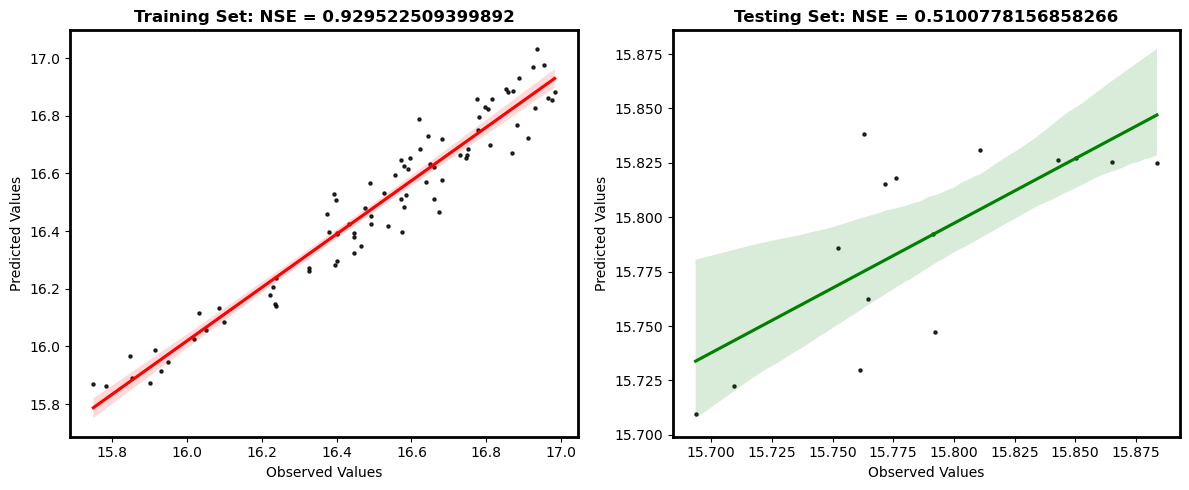

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Plot the observed vs. predicted values for the training set
plt.subplot(1, 2, 1)
sns.regplot(x=results[best_index][1]['y_train_original'], y=results[best_index][1]['train_pred_original'], color='black', scatter_kws={'s':5}, line_kws={'color':'red'})
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
title = results[best_index][1]['nse_train']
plt.title(f'Training Set: NSE = {title}', fontweight='bold')

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Plot the observed vs. predicted values for the testing set
plt.subplot(1, 2, 2)
sns.regplot(x=results[best_index][1]['y_test_original'], y=results[best_index][1]['test_pred_original'], color='black', scatter_kws={'s':5}, line_kws={'color':'green'})
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
title = results[best_index][1]['nse_test']
plt.title(f'Testing Set: NSE = {title}', fontweight='bold')

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
#plt.savefig("01_Hybrid_model_fit_diagram.png", dpi=300)

plt.show()
